In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
plt.style.use('/raid/lingo/akyurek/mplstyle')
plt.rc('font', serif='Times')
plt.rc('text', usetex=False)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
def average_metrics(results):
    """Average the metrics over samples"""
    metrics = {'precision': {}, 'recall': {}}
    for k in (1, 5, 10,  50, 100):
        if type(list(results[0]['precision'].keys())[0]) == str:
            k = str(k)
        metrics['precision'][k] = np.mean([res['precision'][k] for res in results])
        metrics['recall'][k] = np.mean([res['recall'][k] for res in results])
    metrics['mrr'] = np.mean([res['rr'] for res in results])
    metrics['samples'] = results
    return metrics

In [3]:
"""Google cloud directory that stores results of the experiments"""
BASE_DIR = "./"
METRICS_DIR = os.path.join(BASE_DIR, "metrics")

In [4]:
def metrics_to_df(metrics):
    info = copy.deepcopy(metrics)
    for normalization, results in info.items():
        for method, method_results in results.items():
            for layer_config, result in method_results.items():
                if 'samples' in result:
                    del result['samples']
                    result['mrr'] = {'1': result['mrr']}
    df = pd.DataFrame(pd.json_normalize(info, sep="+")).transpose()
    df.index = pd.MultiIndex.from_tuples([tuple(k.split("+")) for k, v in df.iterrows()])
    df = pd.melt(df.transpose())
    df.columns = ['normalization', 'eval', 'layers', 'metrics', 'k', 'score']
    df['layer_type'] = 'A'
    df.loc[df['layers'].str.contains('gradients'), 'layer_type'] = 'gradients'
    df.loc[(df['layers'].str.contains('gradients')) & (df['layers'].str.contains('activations')), 'layer_type'] = 'gradients_and_activations'
    df.loc[(df['layers'] == 'random') | (df['layers'] == 'bm25plus'), 'layer_type'] = 'baseline'
    df = df.replace({'gradients':'G', 'activations': 'A', 'block.': '', 'encoder': 'E', 'decoder': 'D', 'shared': 'embed', 'random': 'Target-Picker'}, regex=True)
    return df

In [12]:
def plot_with_filter(df, filter = lambda x: x, title="Title"):
    plt.figure(figsize=(16, 6))
    sns.scatterplot(data=filter(df), x='layers', y='score', style='normalization', hue='layer_type')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()
    #plt.savefig("plots/"+title+".jpeg")

In [13]:
def visualize_one_experiment(path='/reranker/bm2plus_wbaselines_eos_corrects_all.json', suffix=""):
    with open(METRICS_DIR + path) as f:
      reranker_metrics = json.load(f)
      
    df = metrics_to_df(reranker_metrics)
    for method in ("full", "collapse", "target_abstracts"):
      plot_with_filter(df, filter = lambda x: x[(x['metrics'] == 'precision') & (x['k'] == '5')  & (x['eval'] == method)], title=f'precision@5 ({method} + {suffix})')
      plot_with_filter(df, filter = lambda x: x[(x['metrics'] == 'recall') & (x['k'] == '5') & (x['eval'] == method)], title=f'recall@5 ({method} + {suffix})')
      plot_with_filter(df, filter = lambda x: x[(x['metrics'] == 'mrr') & (x['k'] == '1') & (x['eval'] == method)], title=f'mrr ({method} + {suffix})')
  

In [14]:
with open(METRICS_DIR + '/reranker/bm25plusv3_multi_eos__corrects.json') as f:
    reranker_metrics = json.load(f)

In [15]:
len(reranker_metrics['cosine']['full']['gradients.']['samples'])

21

In [16]:
len(reranker_metrics['cosine']['target_abstracts']['gradients.']['samples'])

20

In [17]:
len(reranker_metrics['cosine']['collapse']['gradients.']['samples'])

21

## Eval on correct samples (+eos)

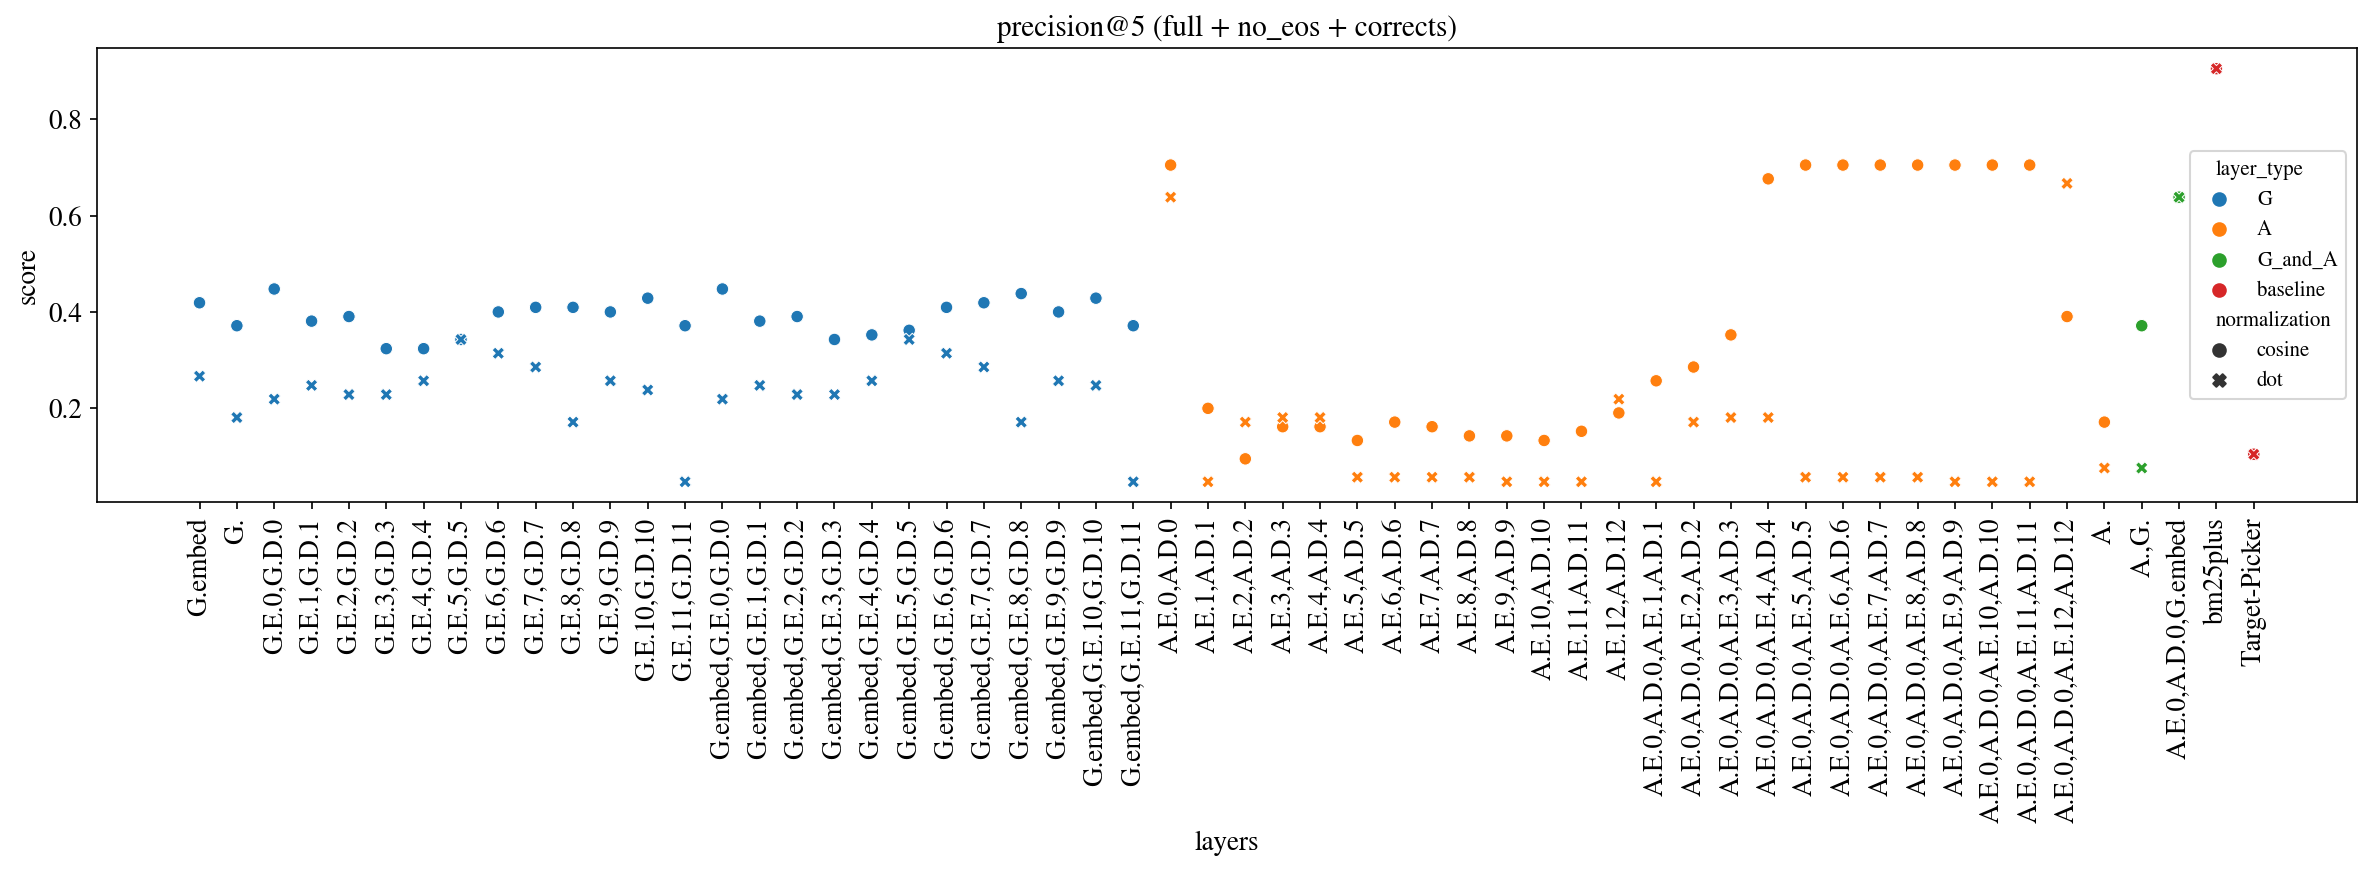

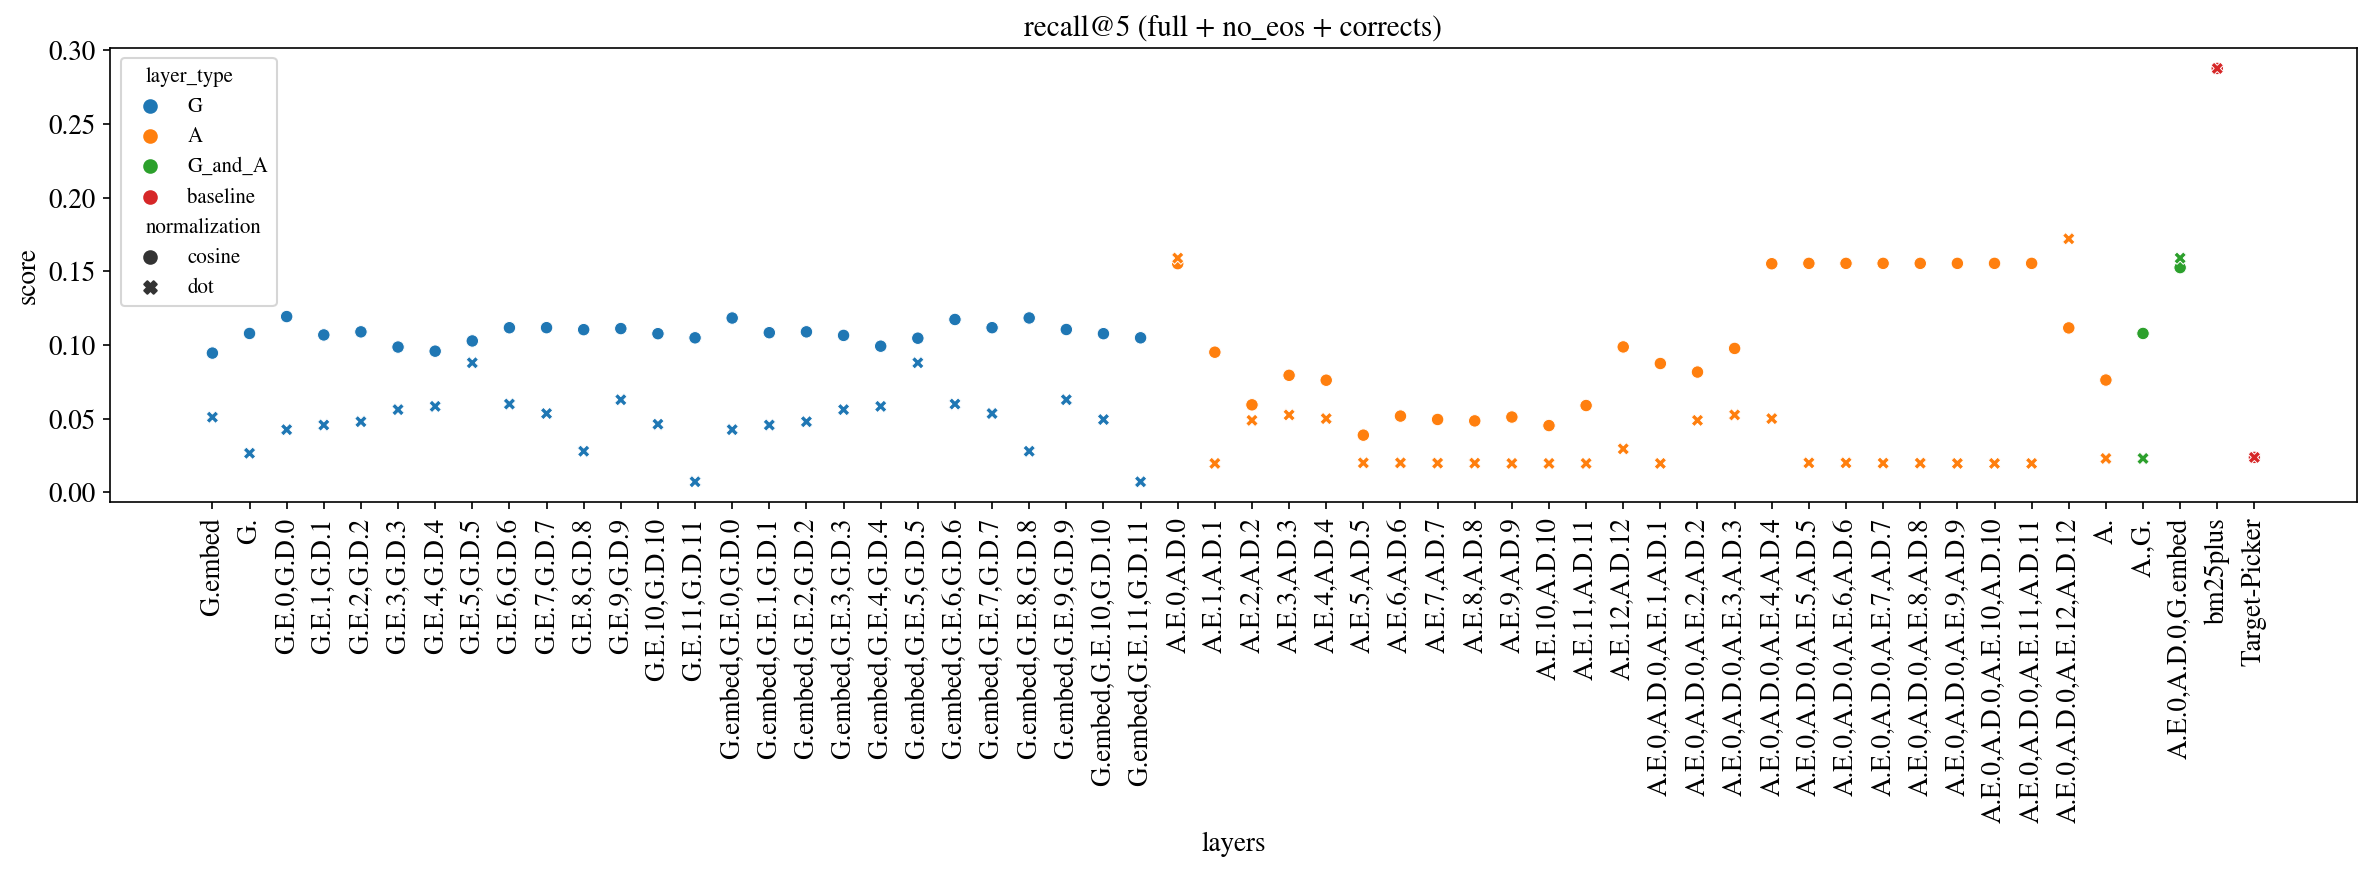

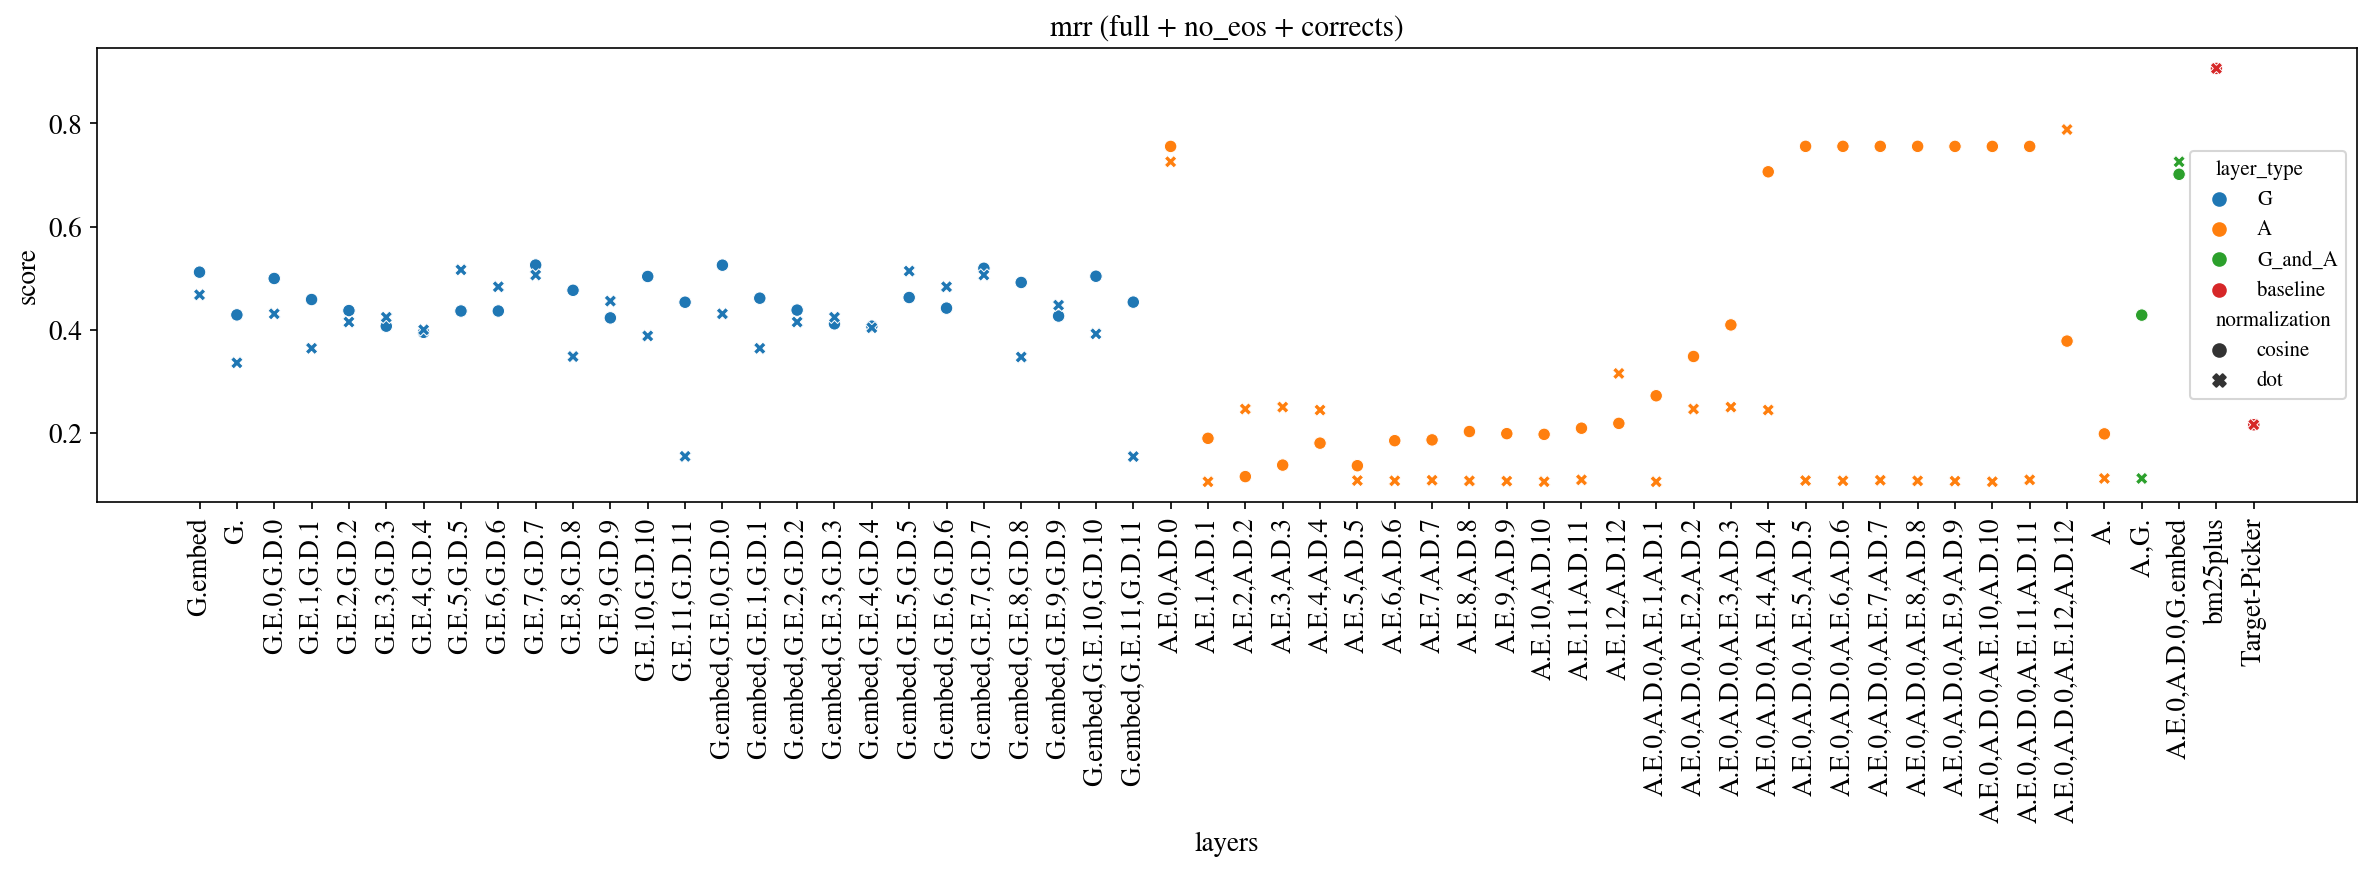

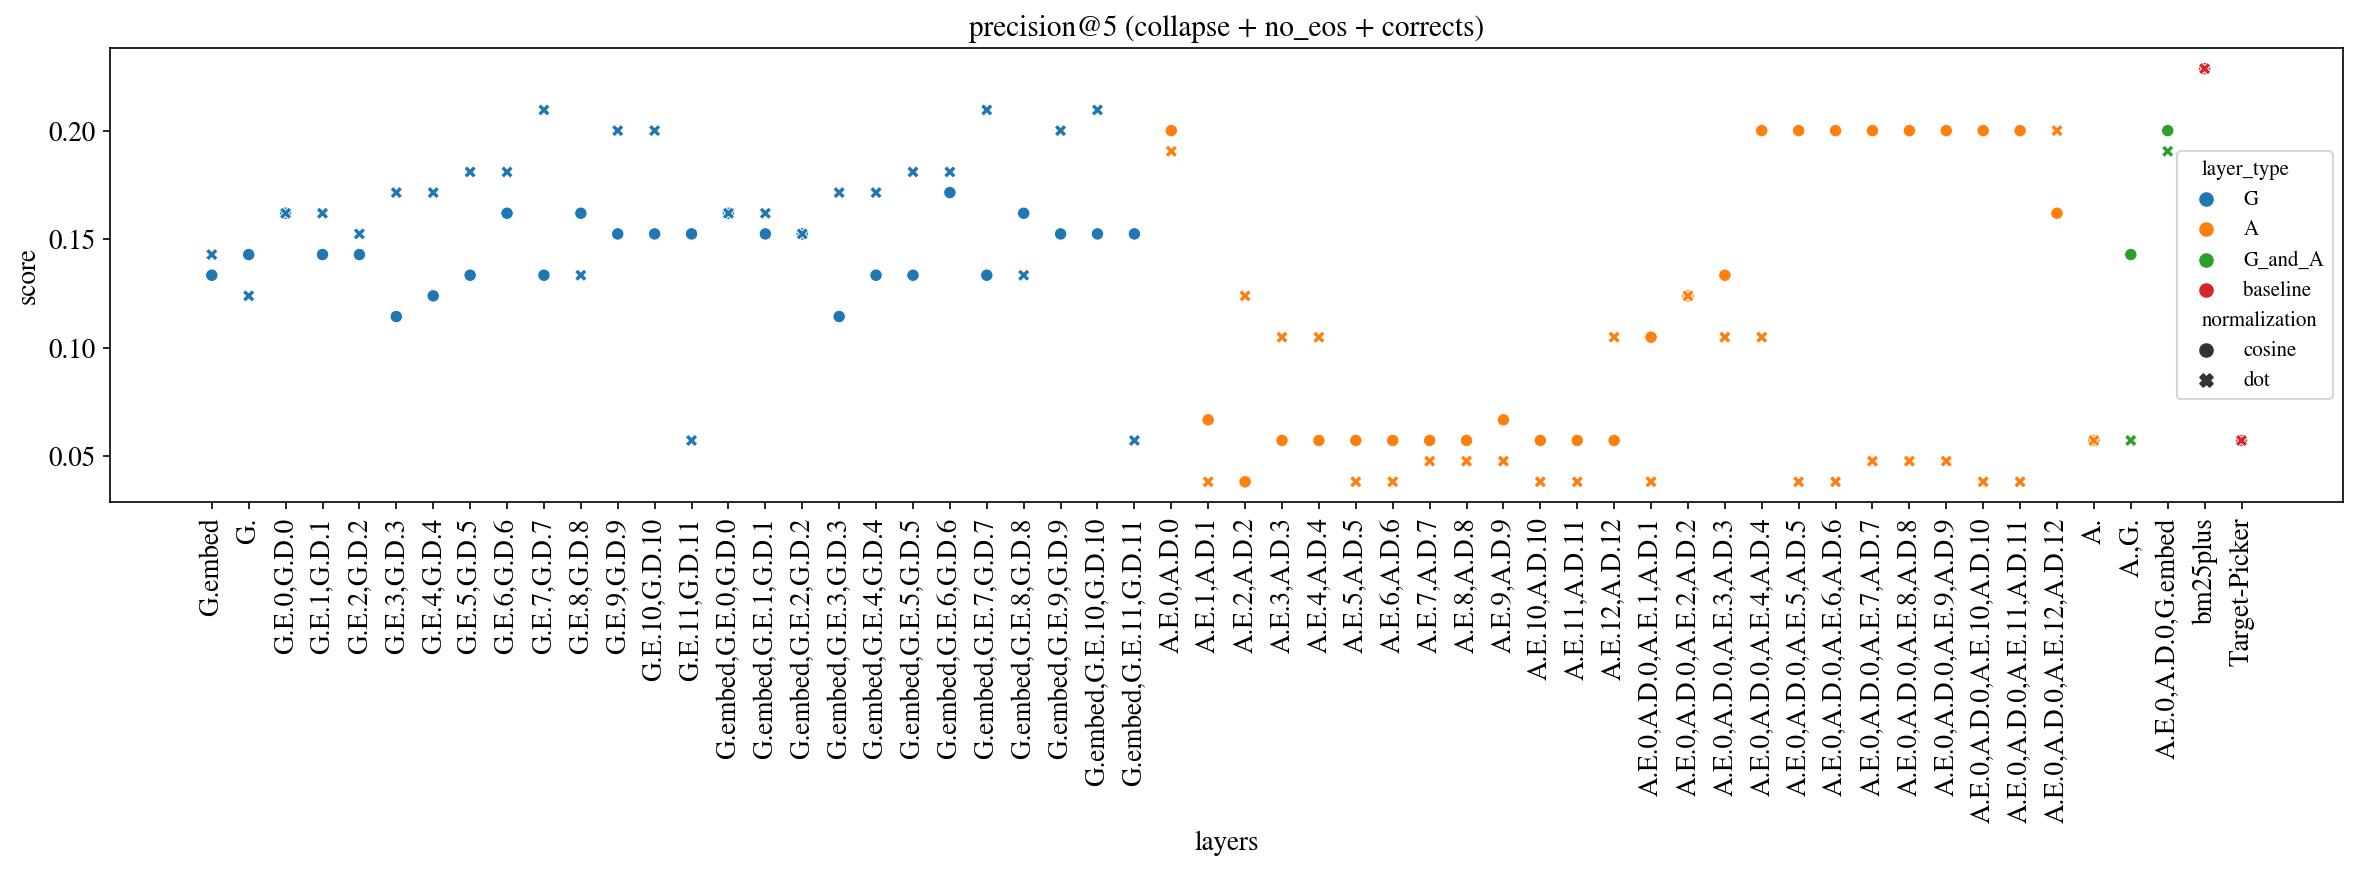

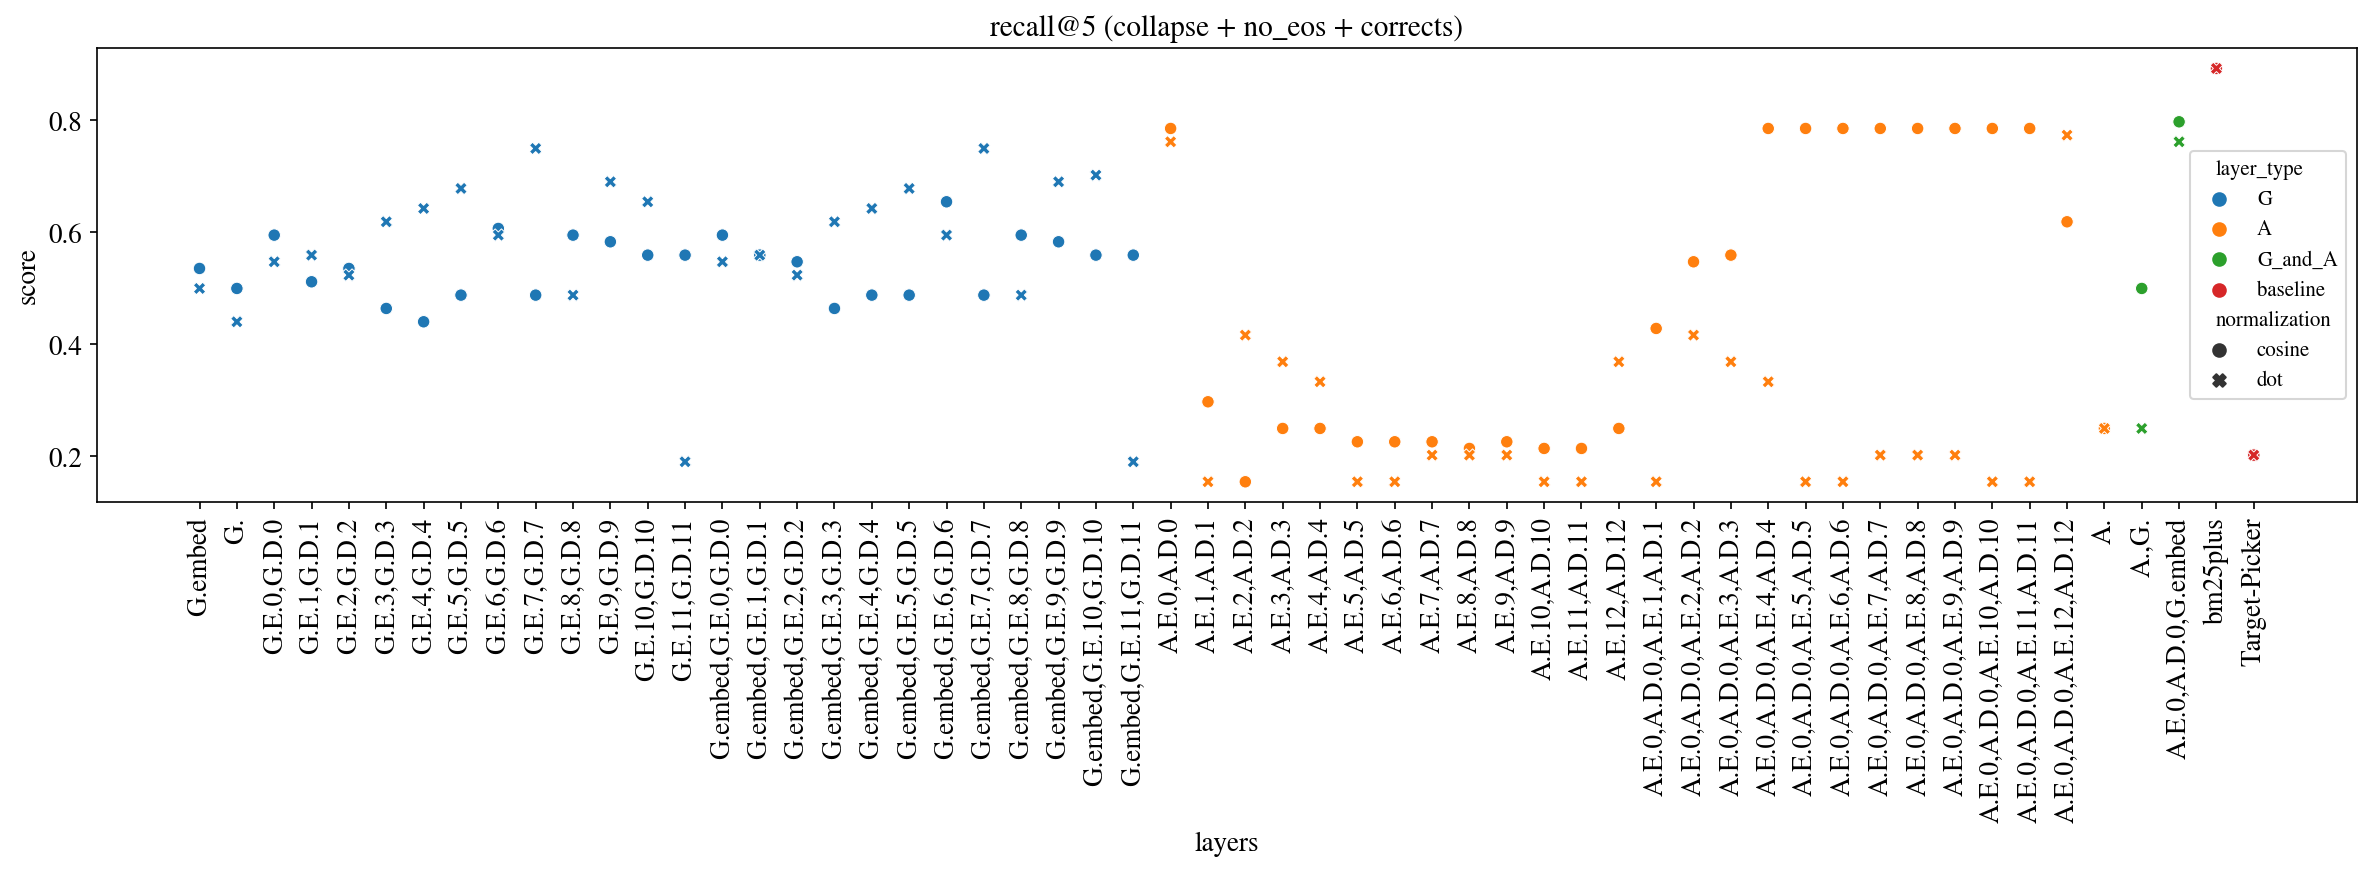

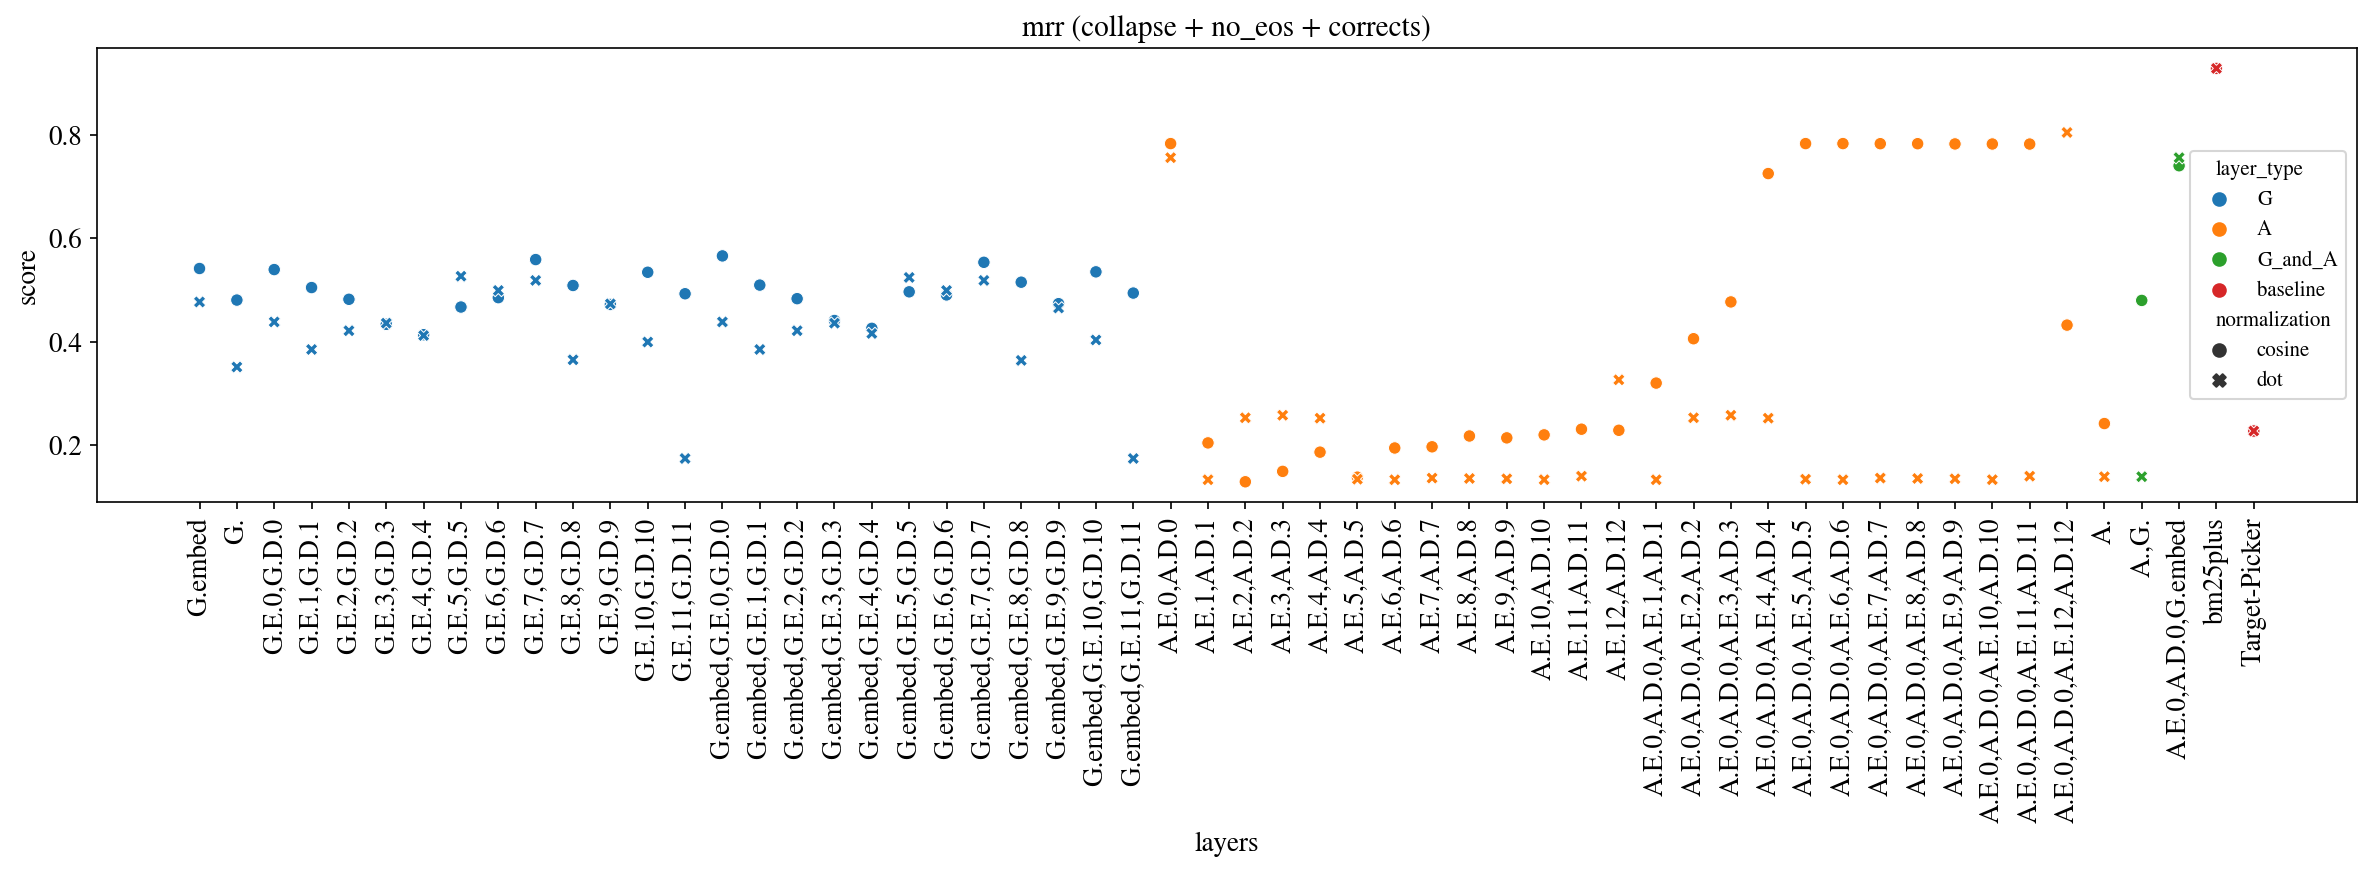

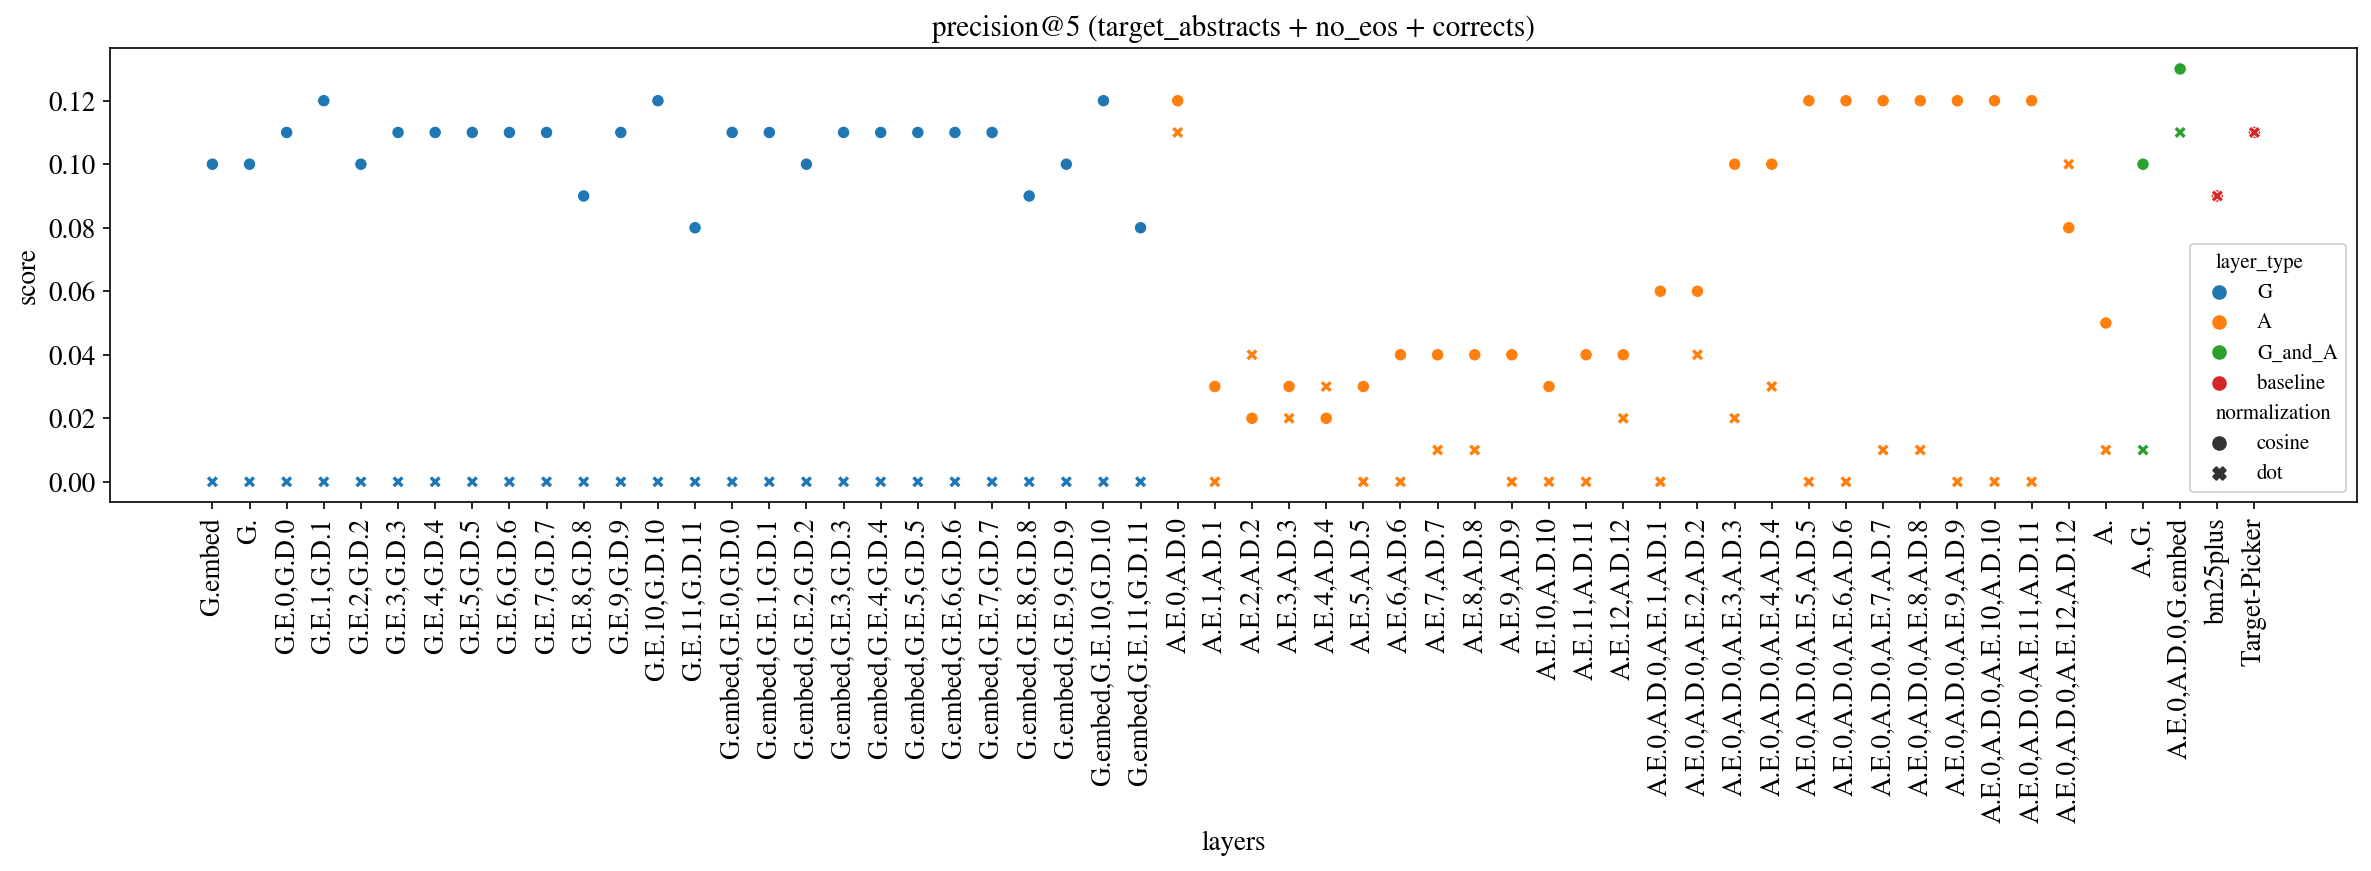

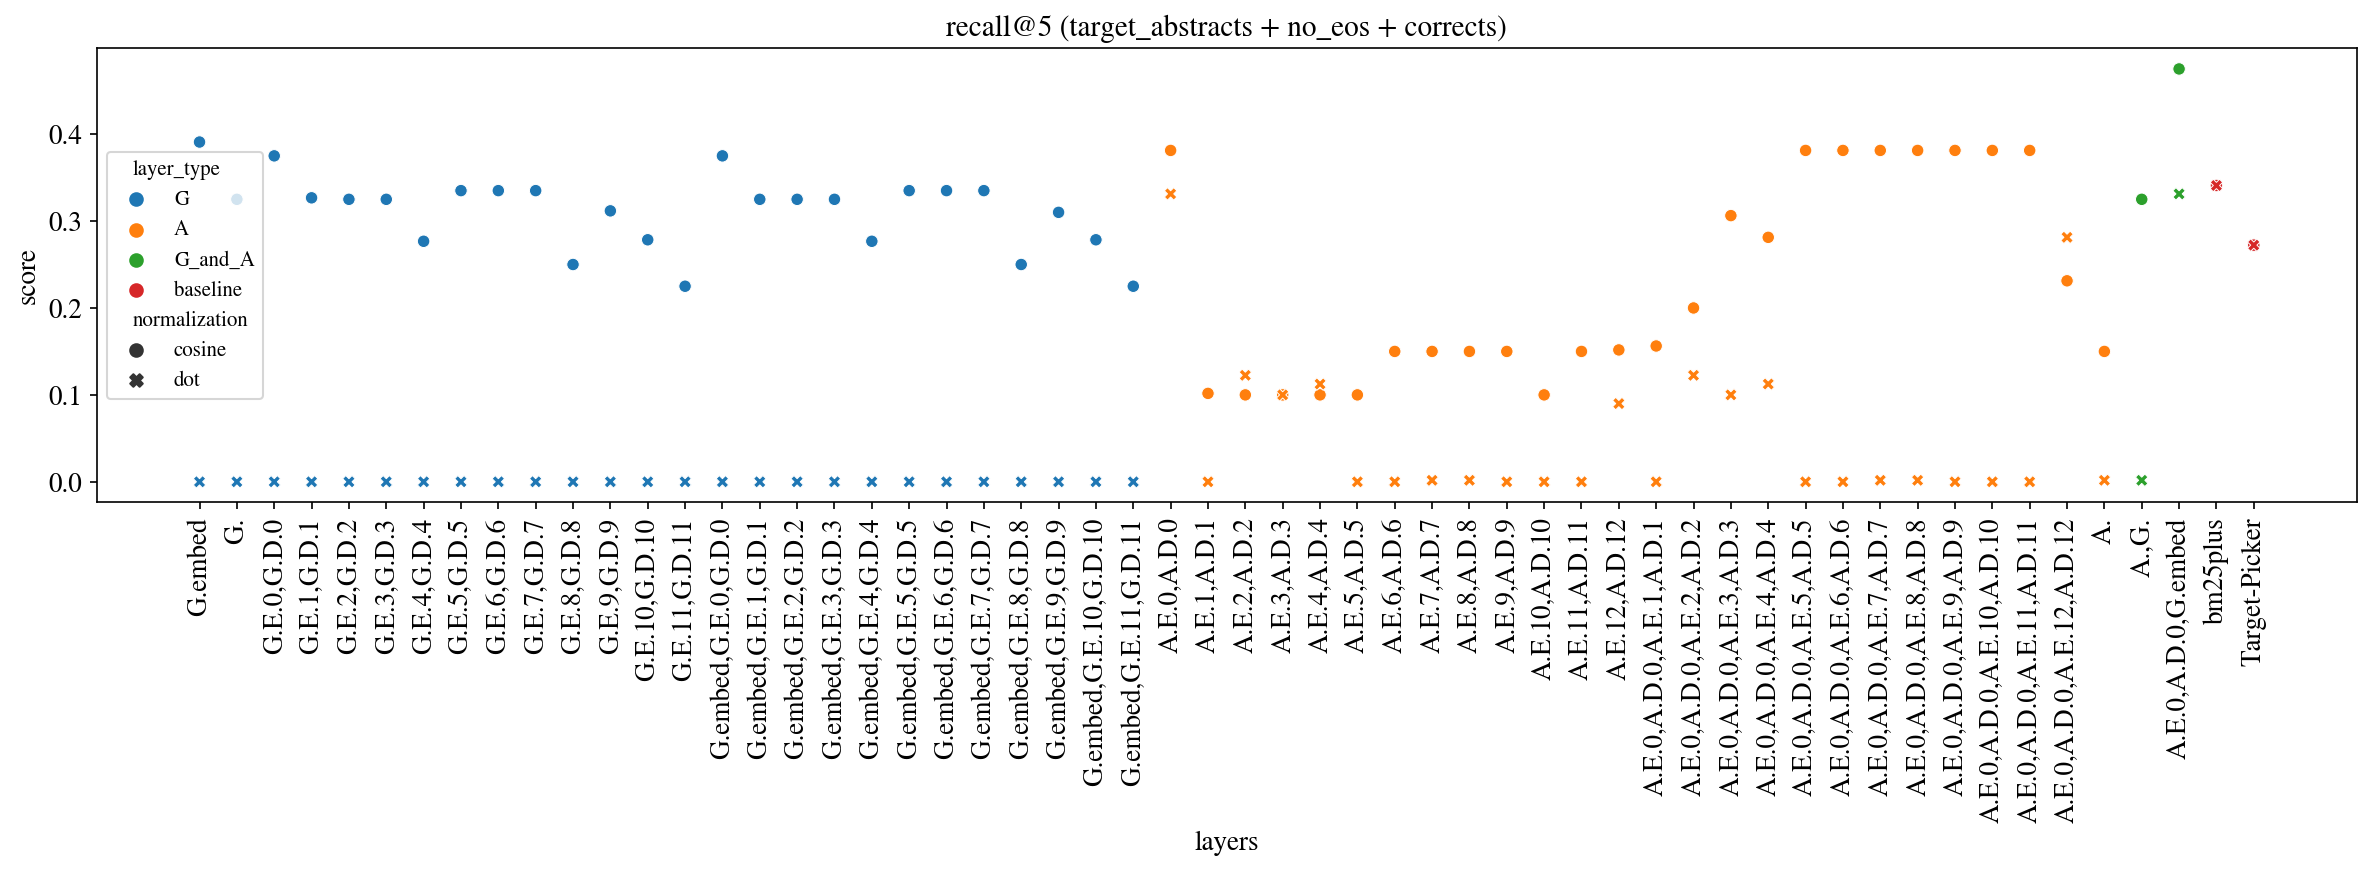

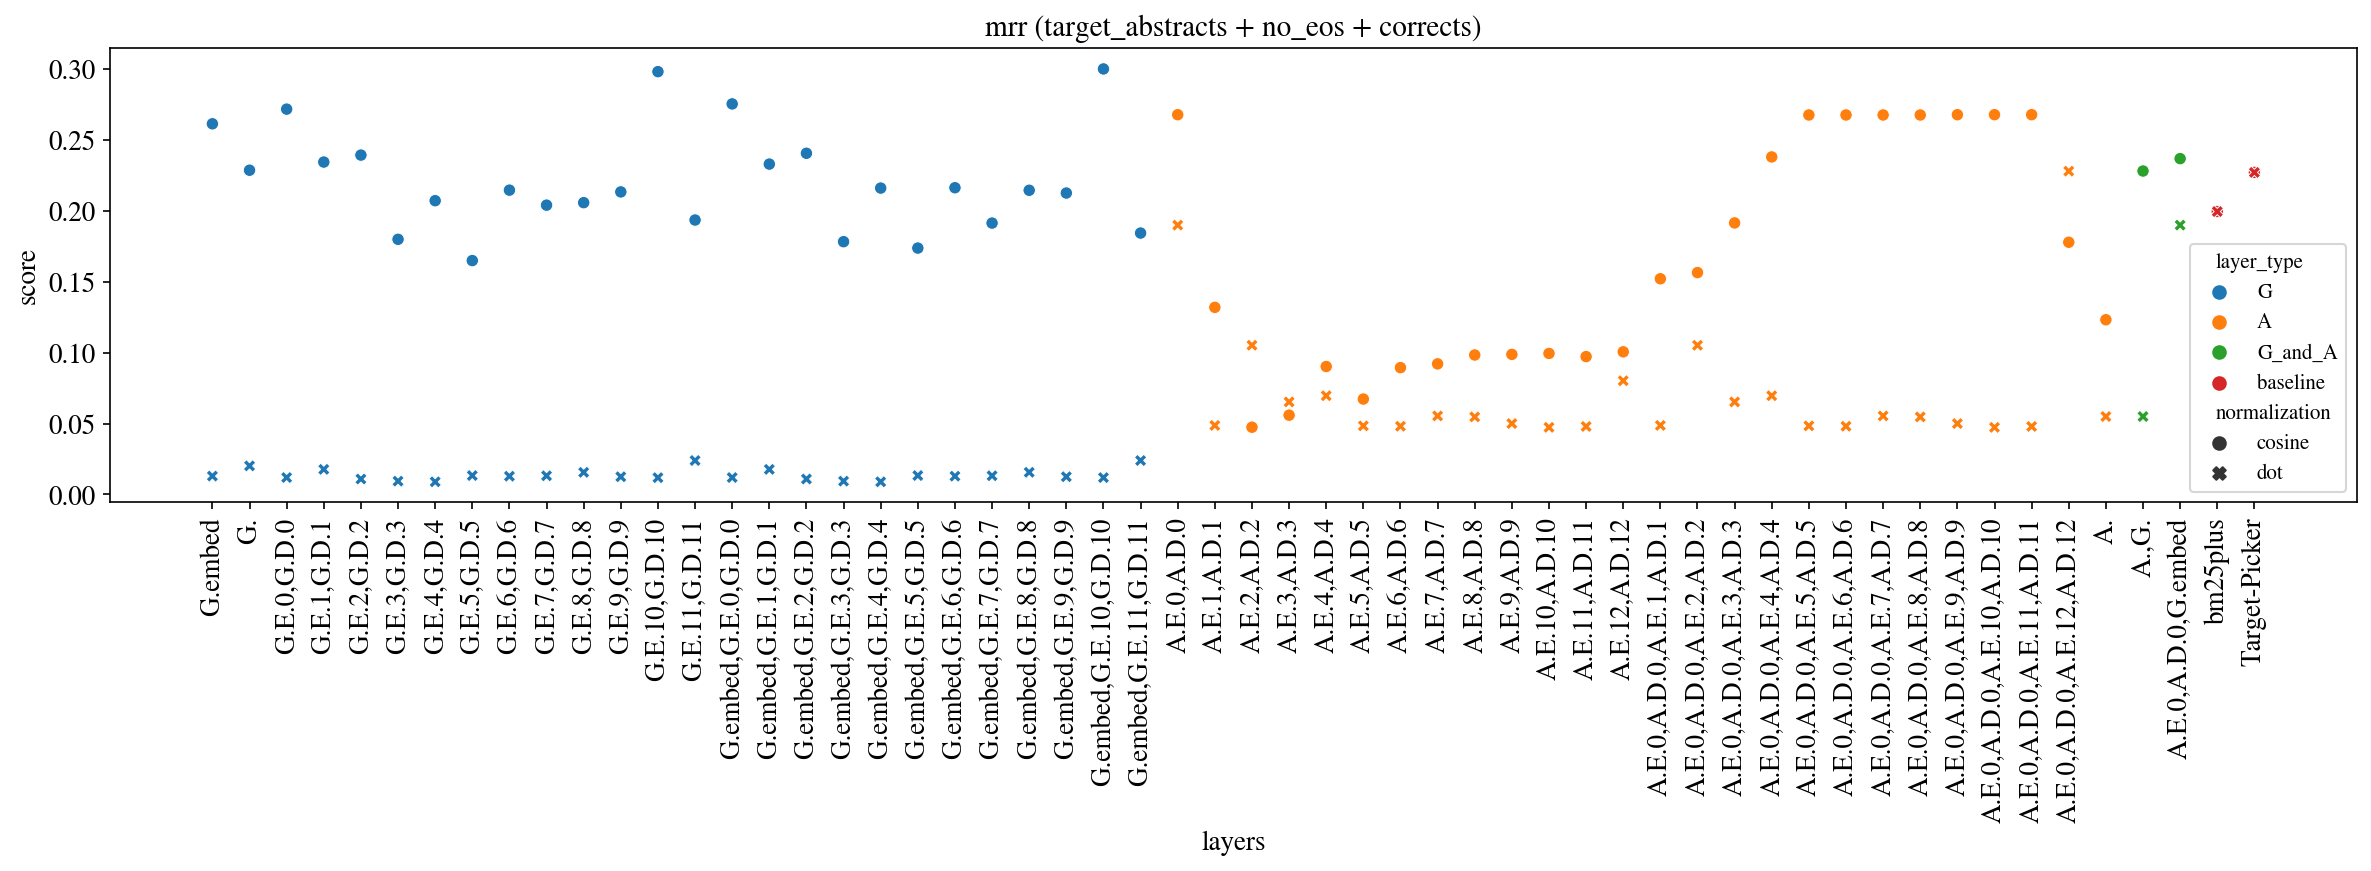

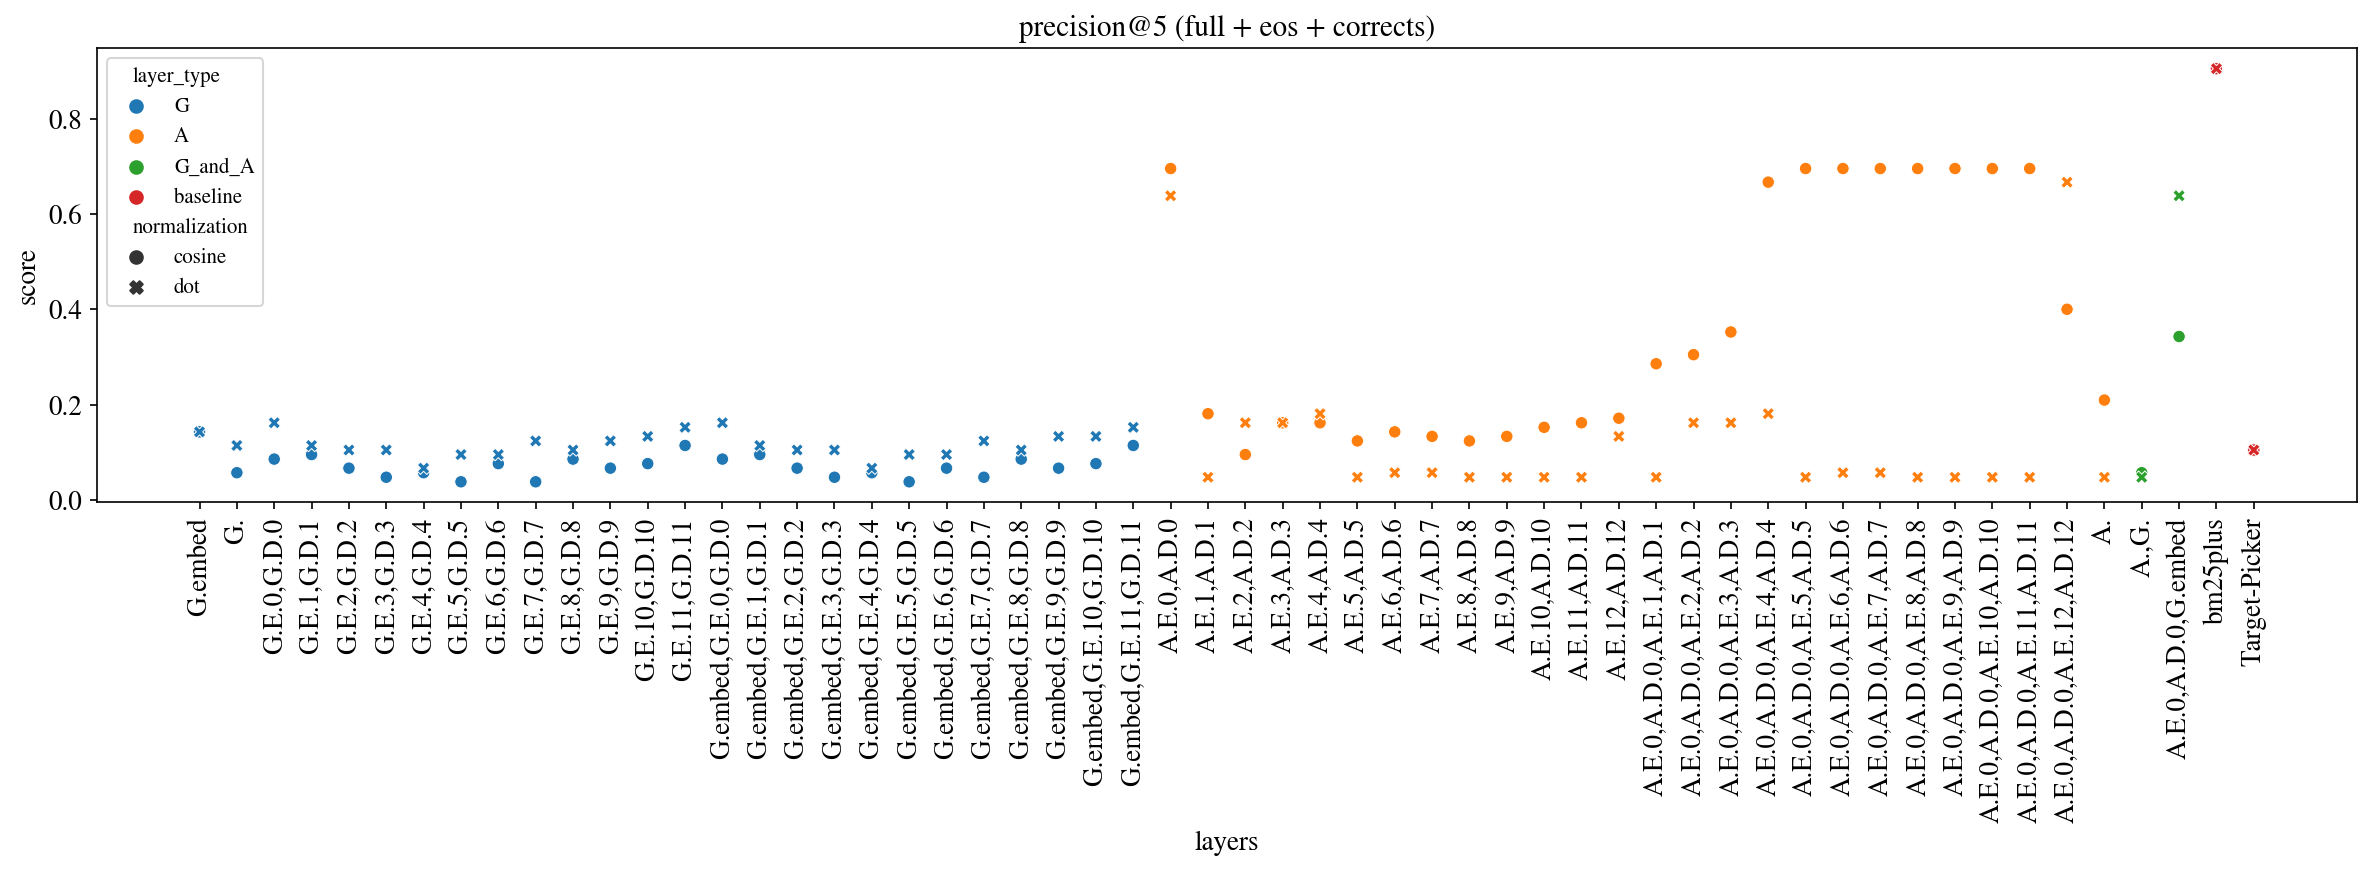

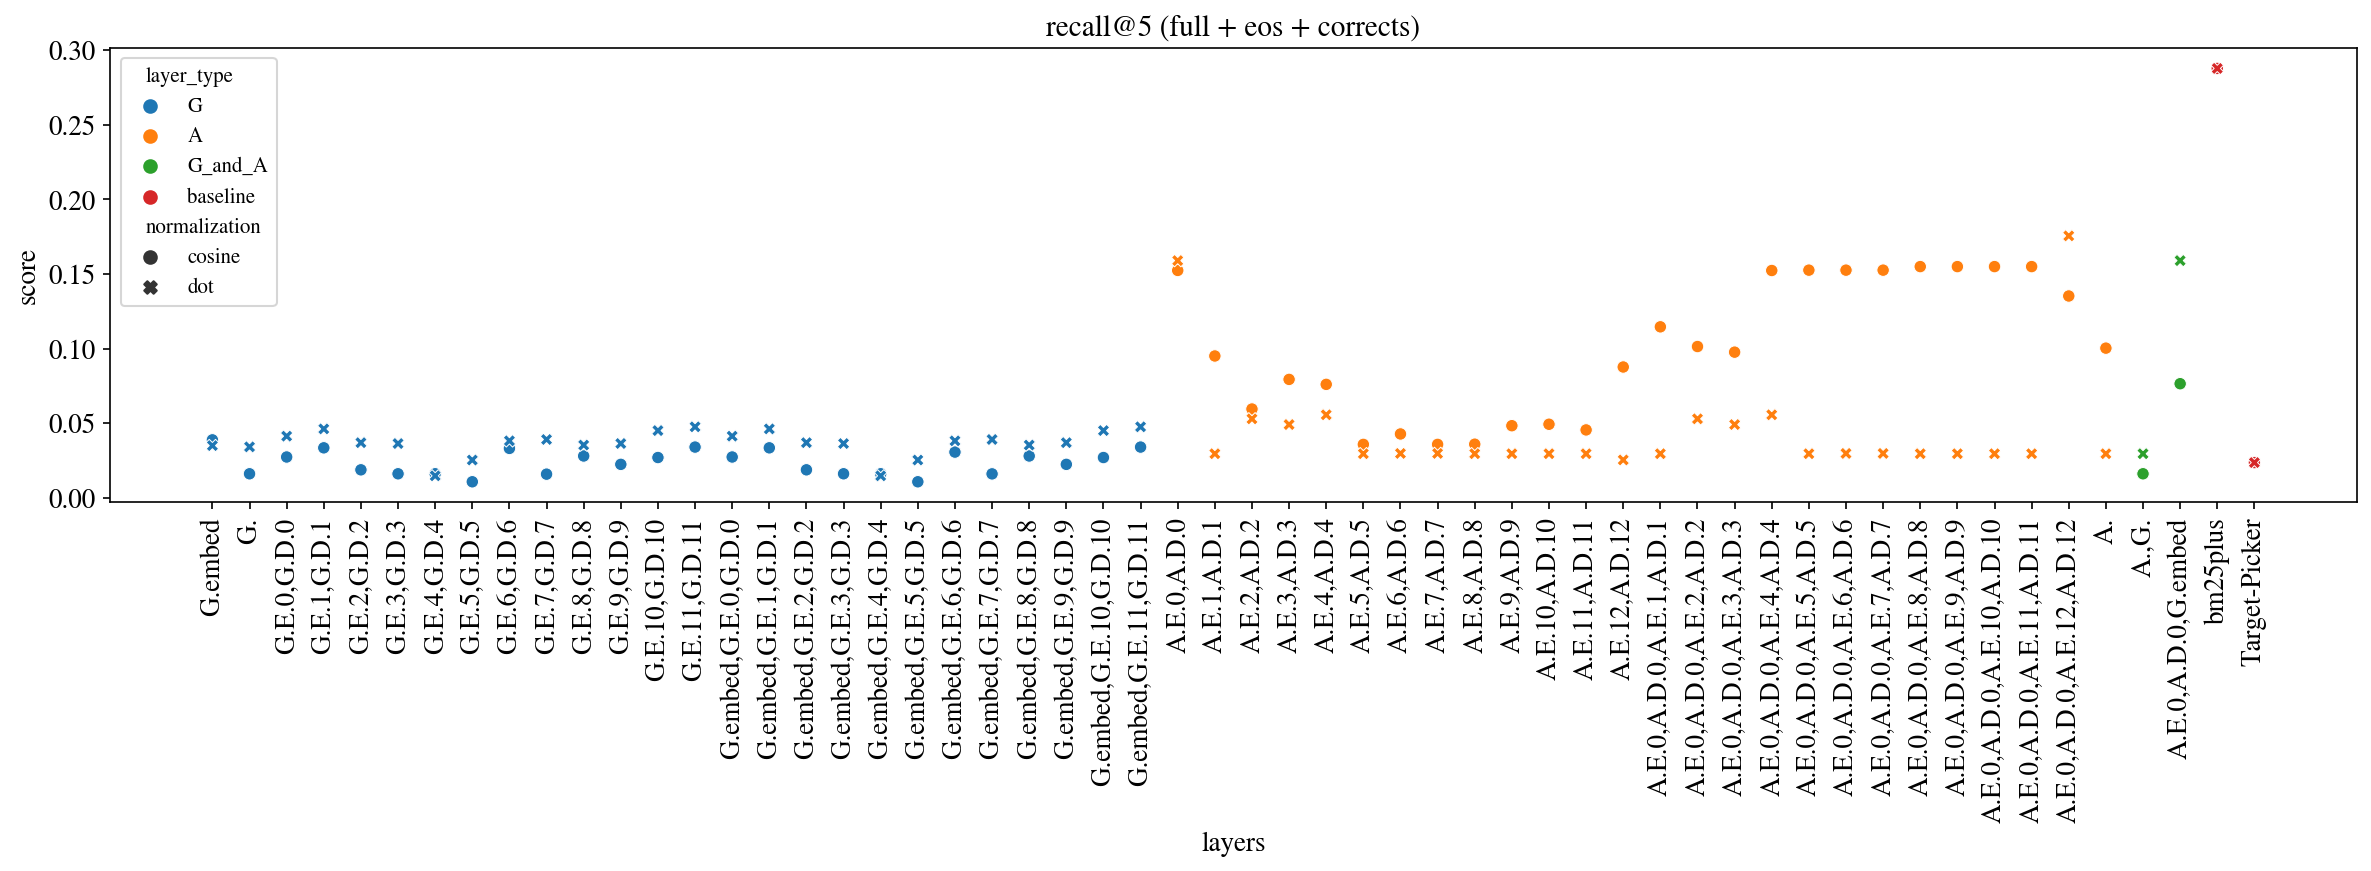

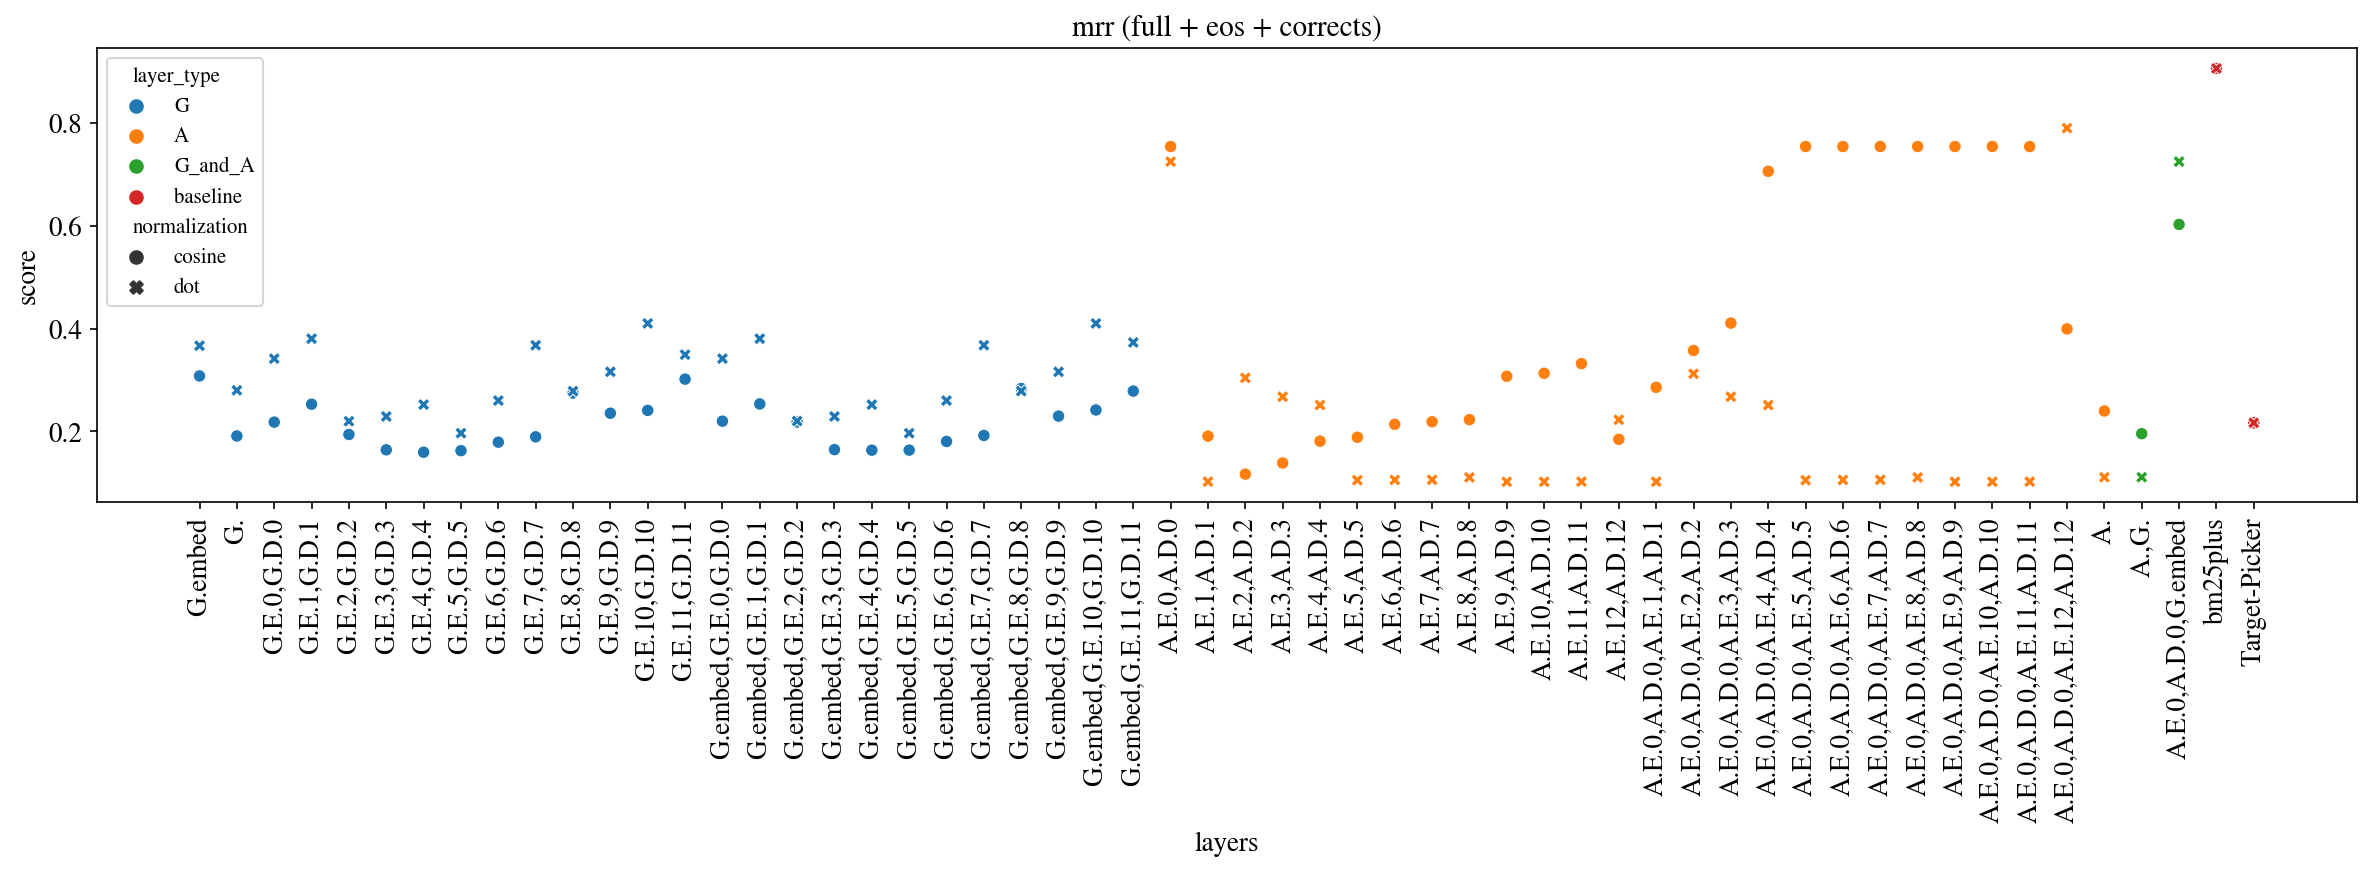

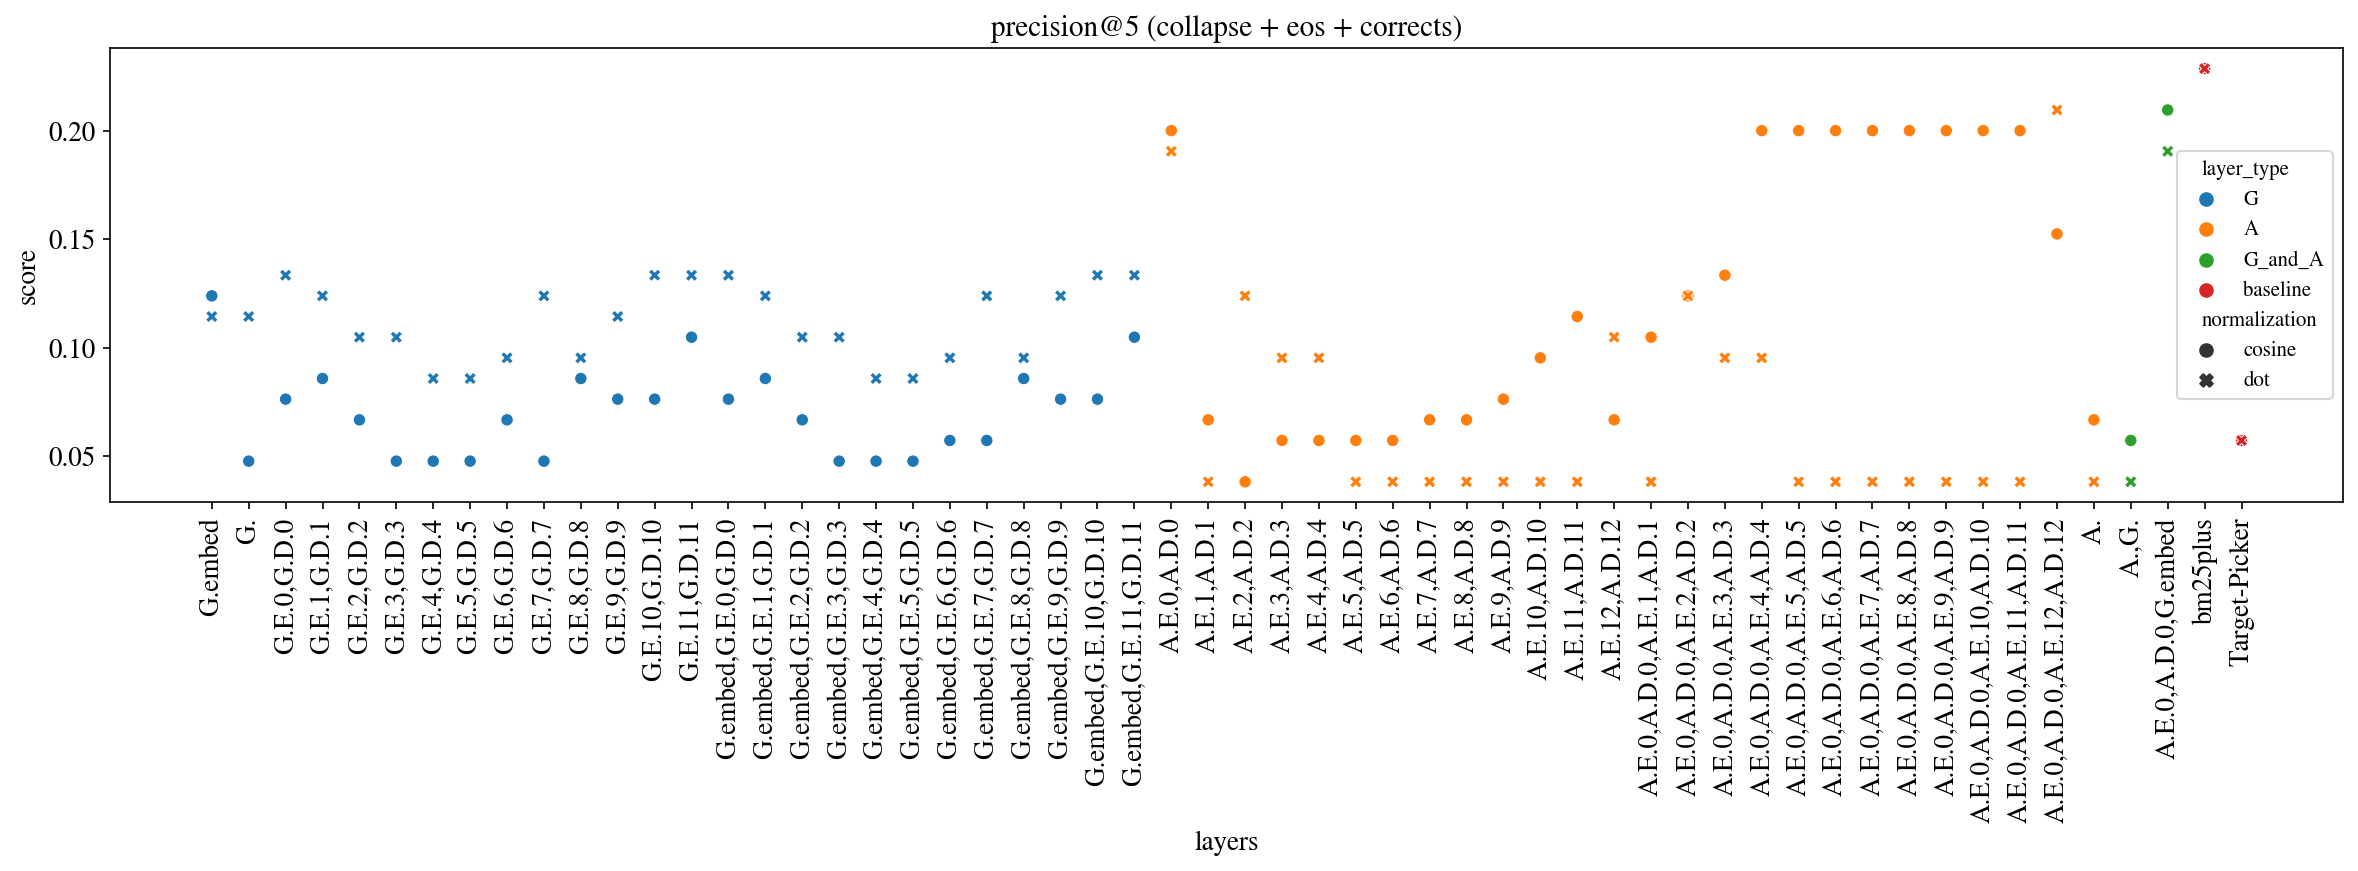

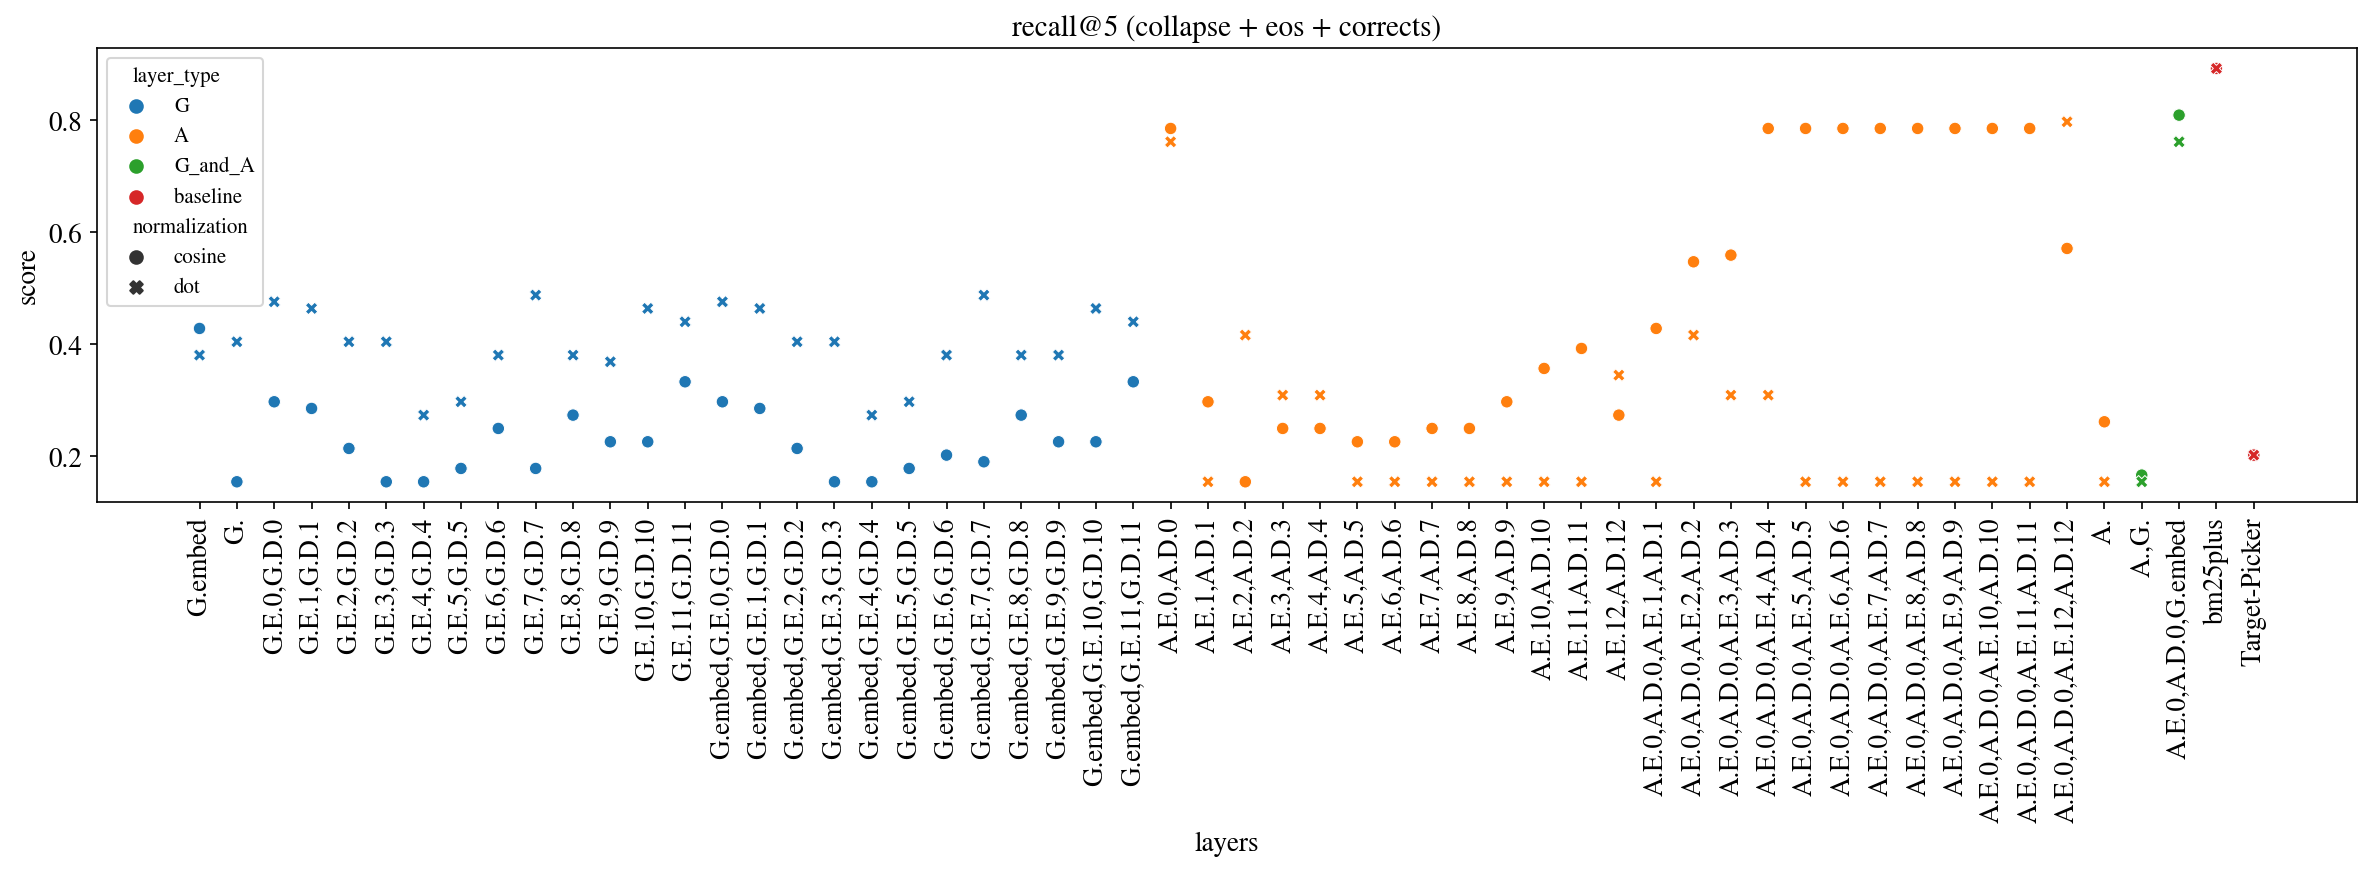

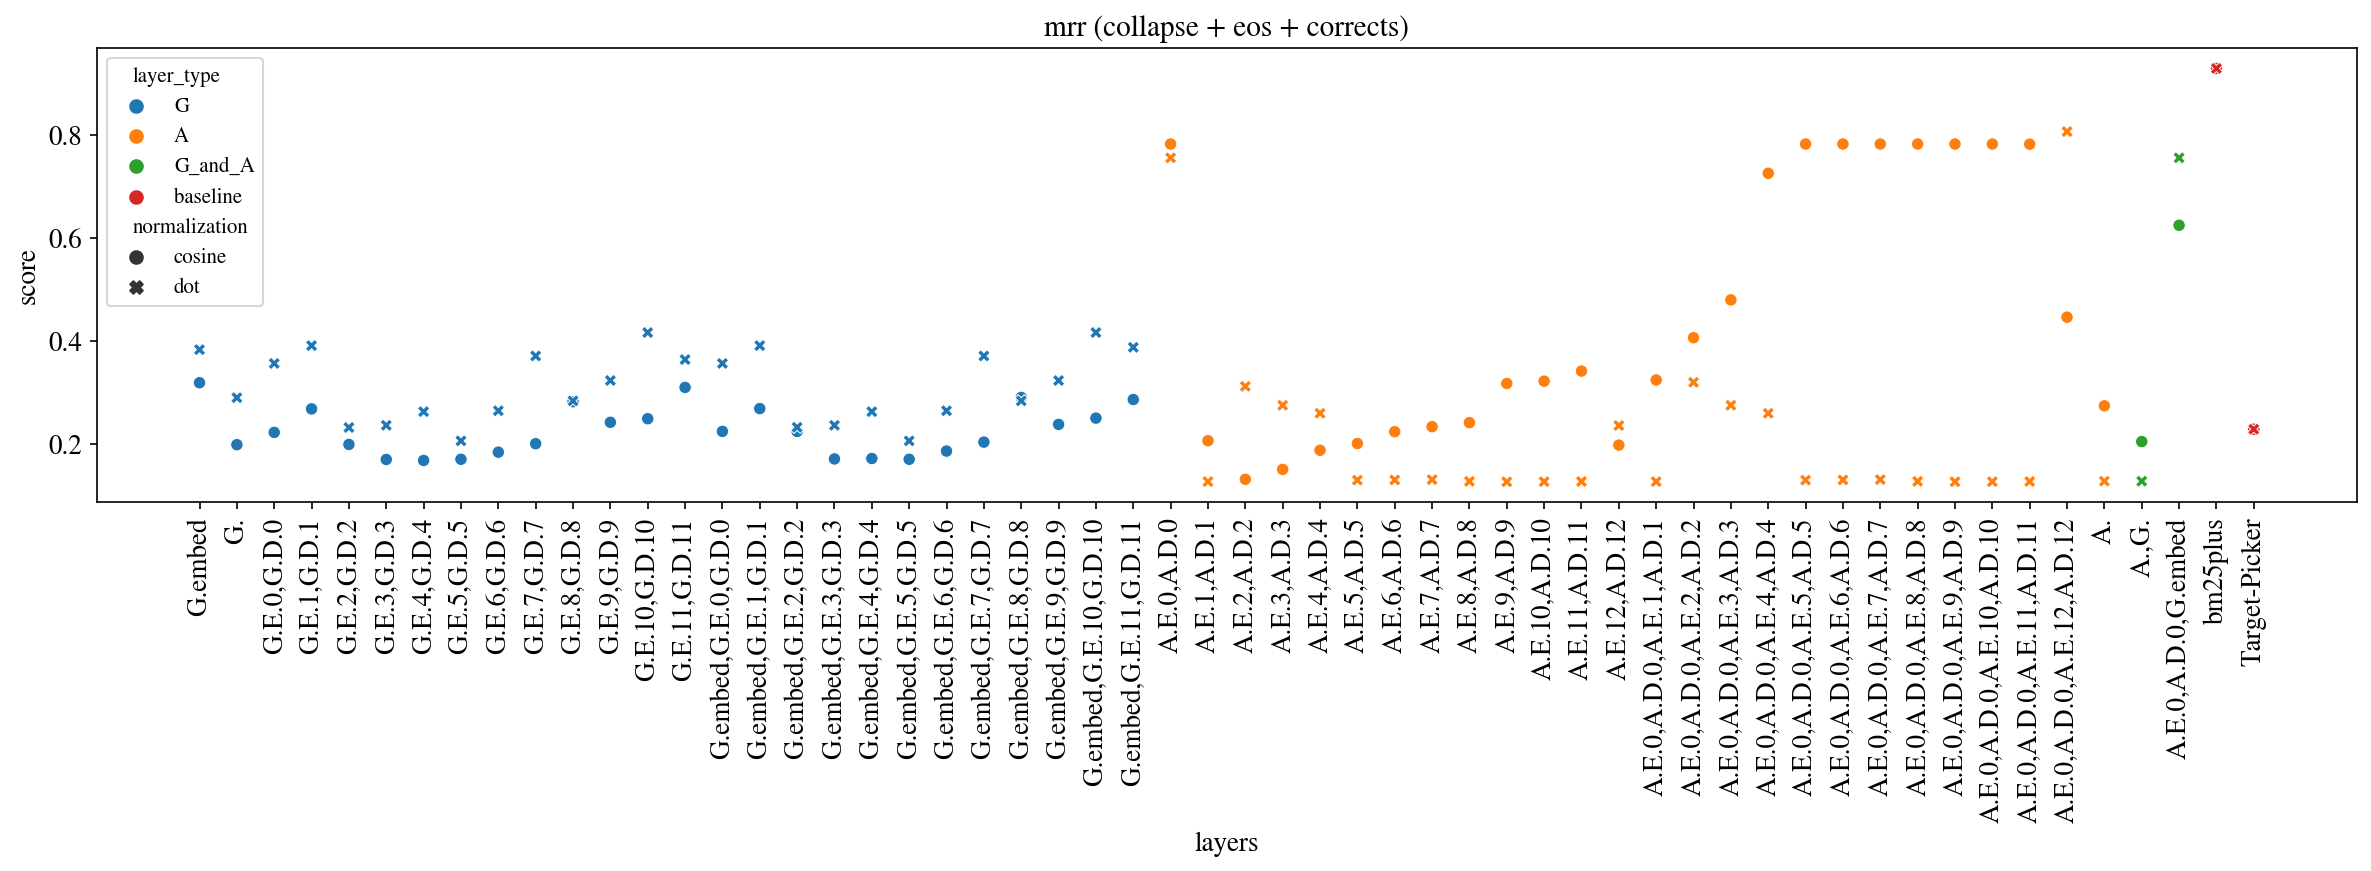

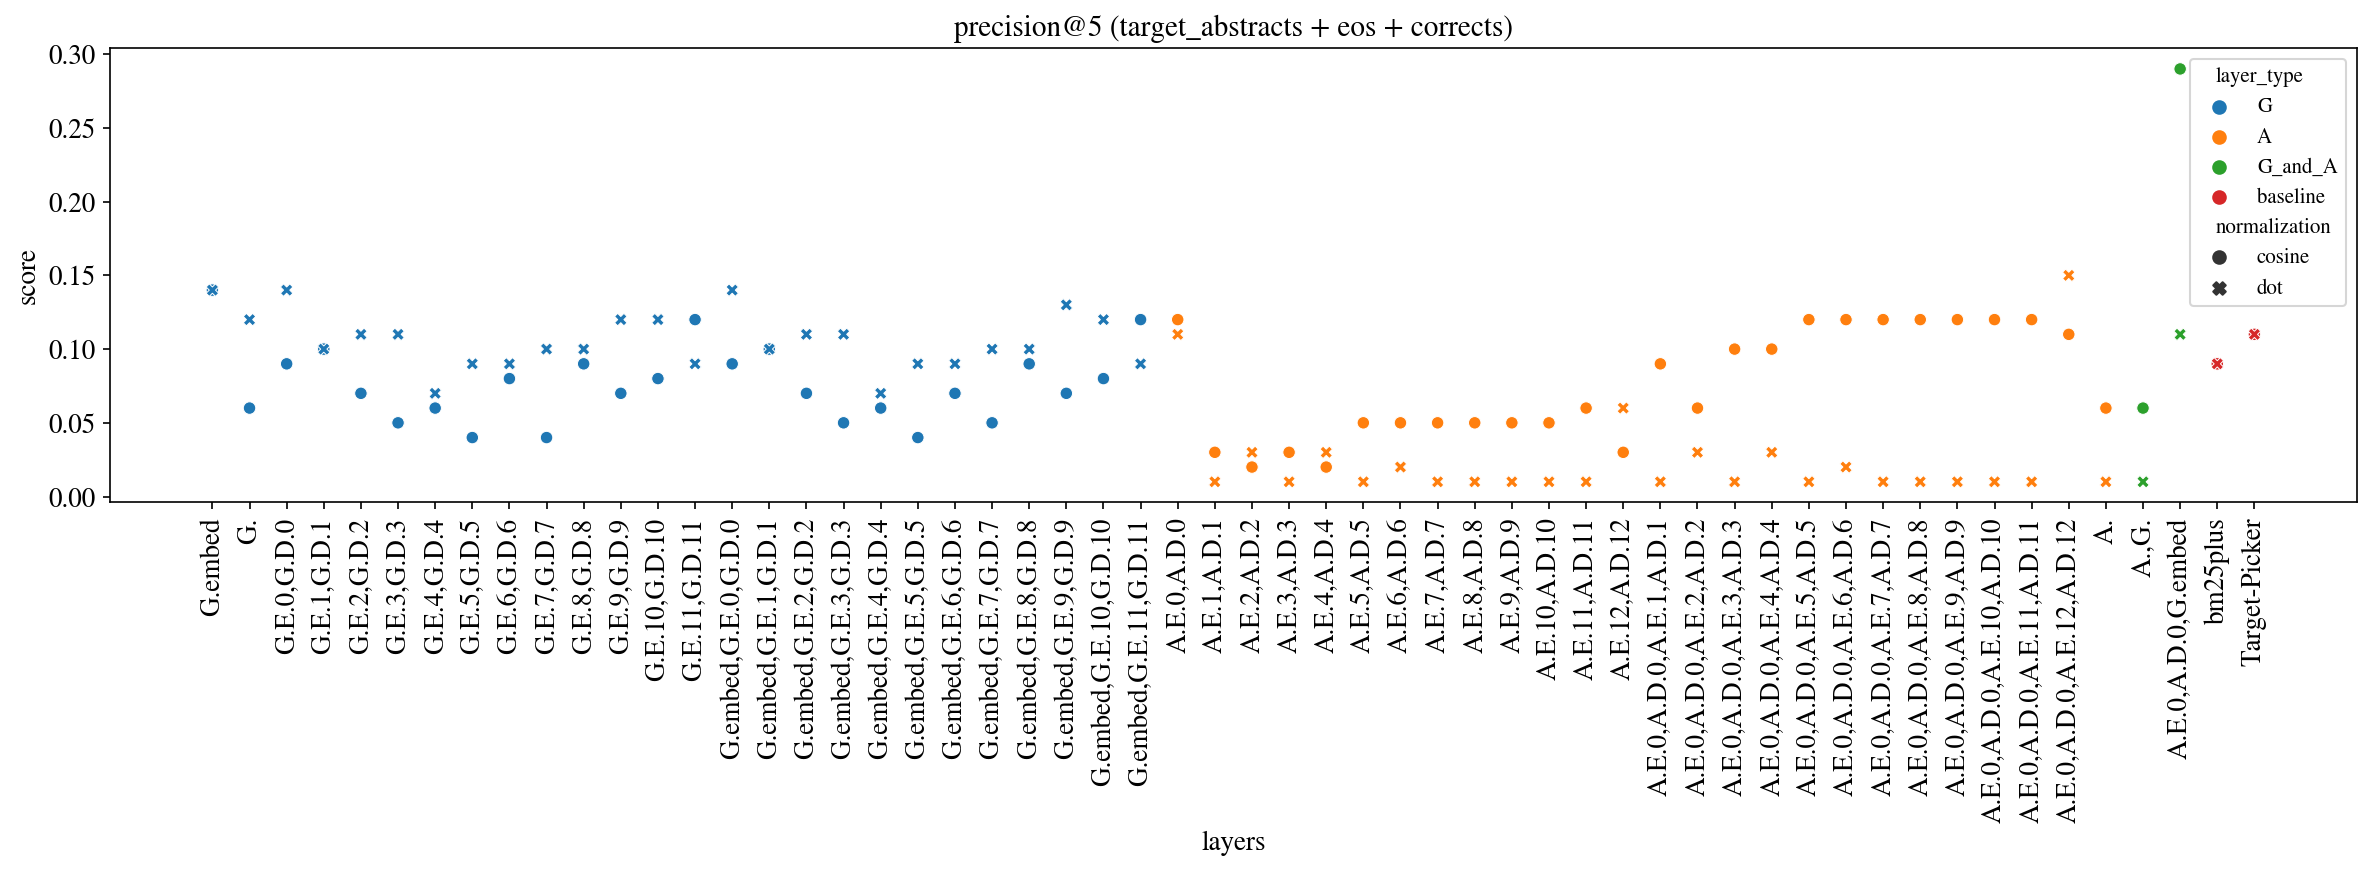

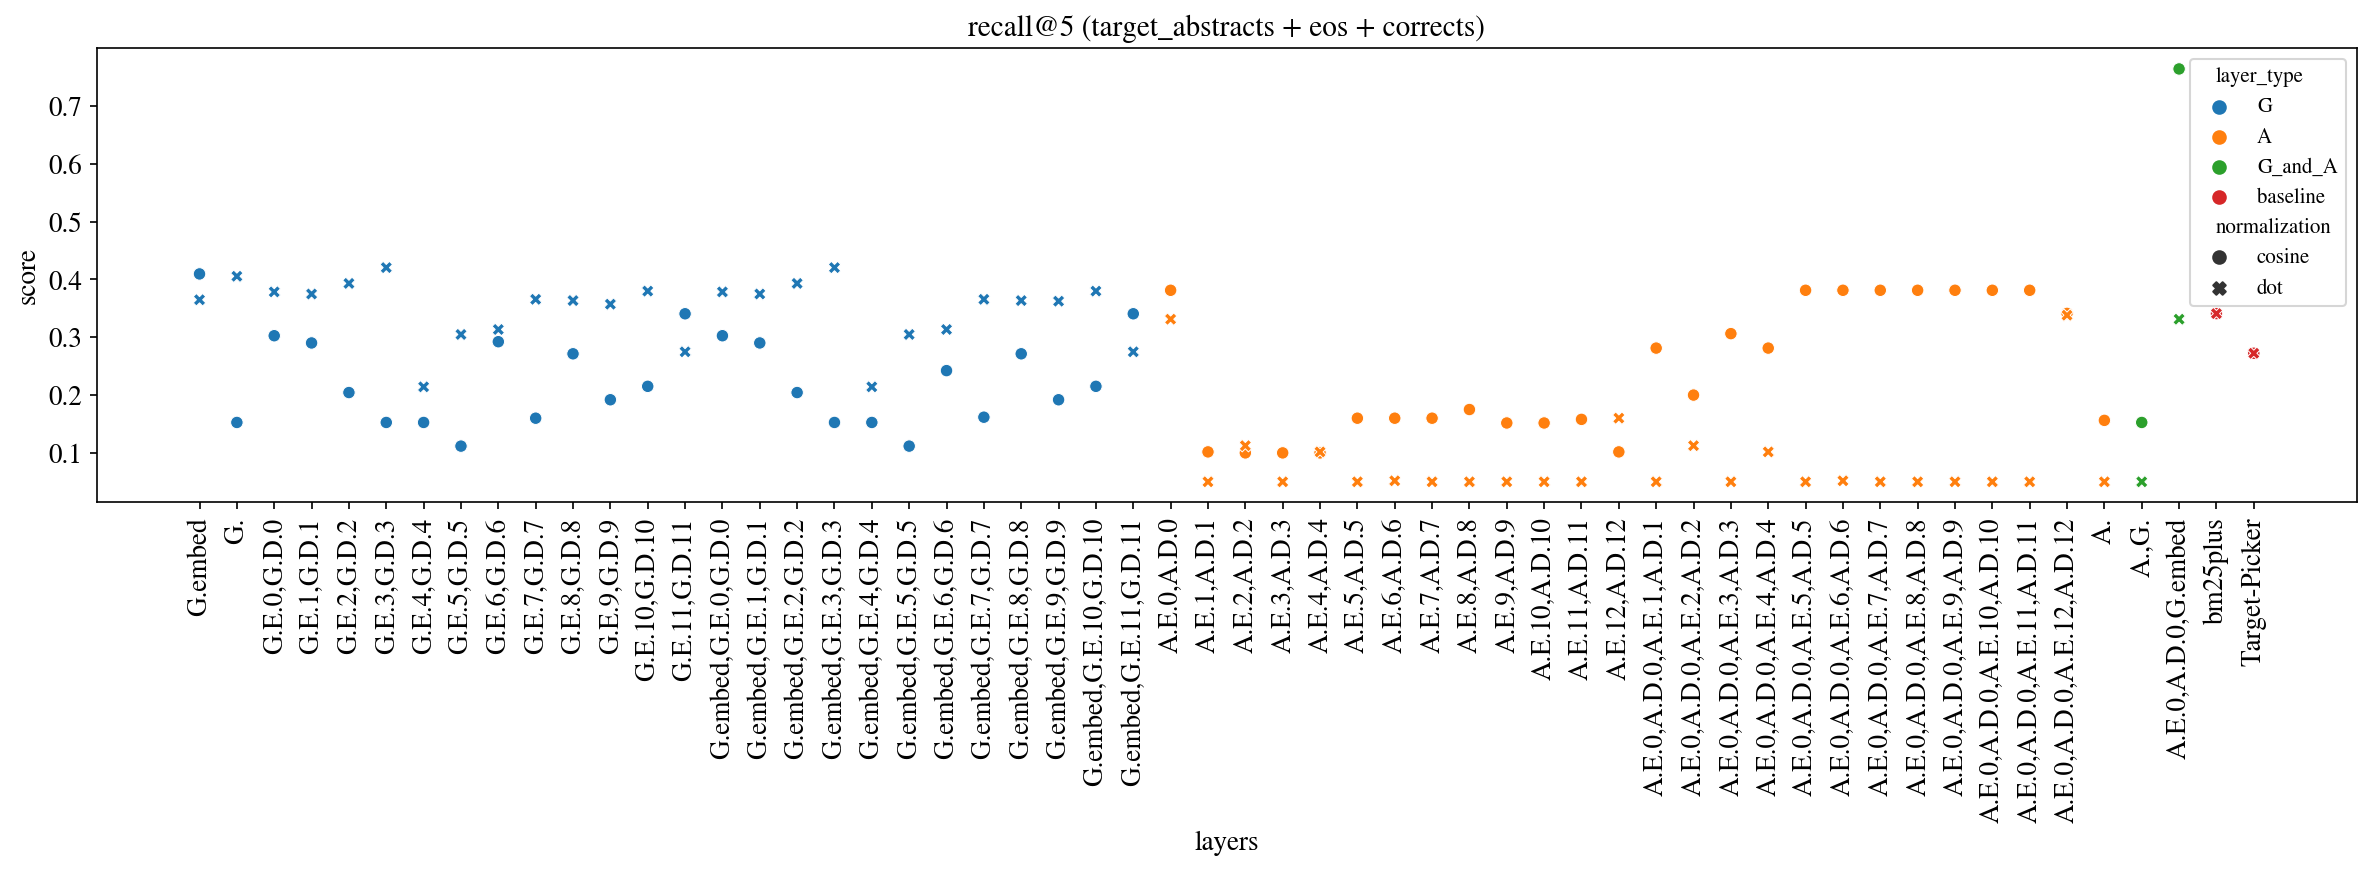

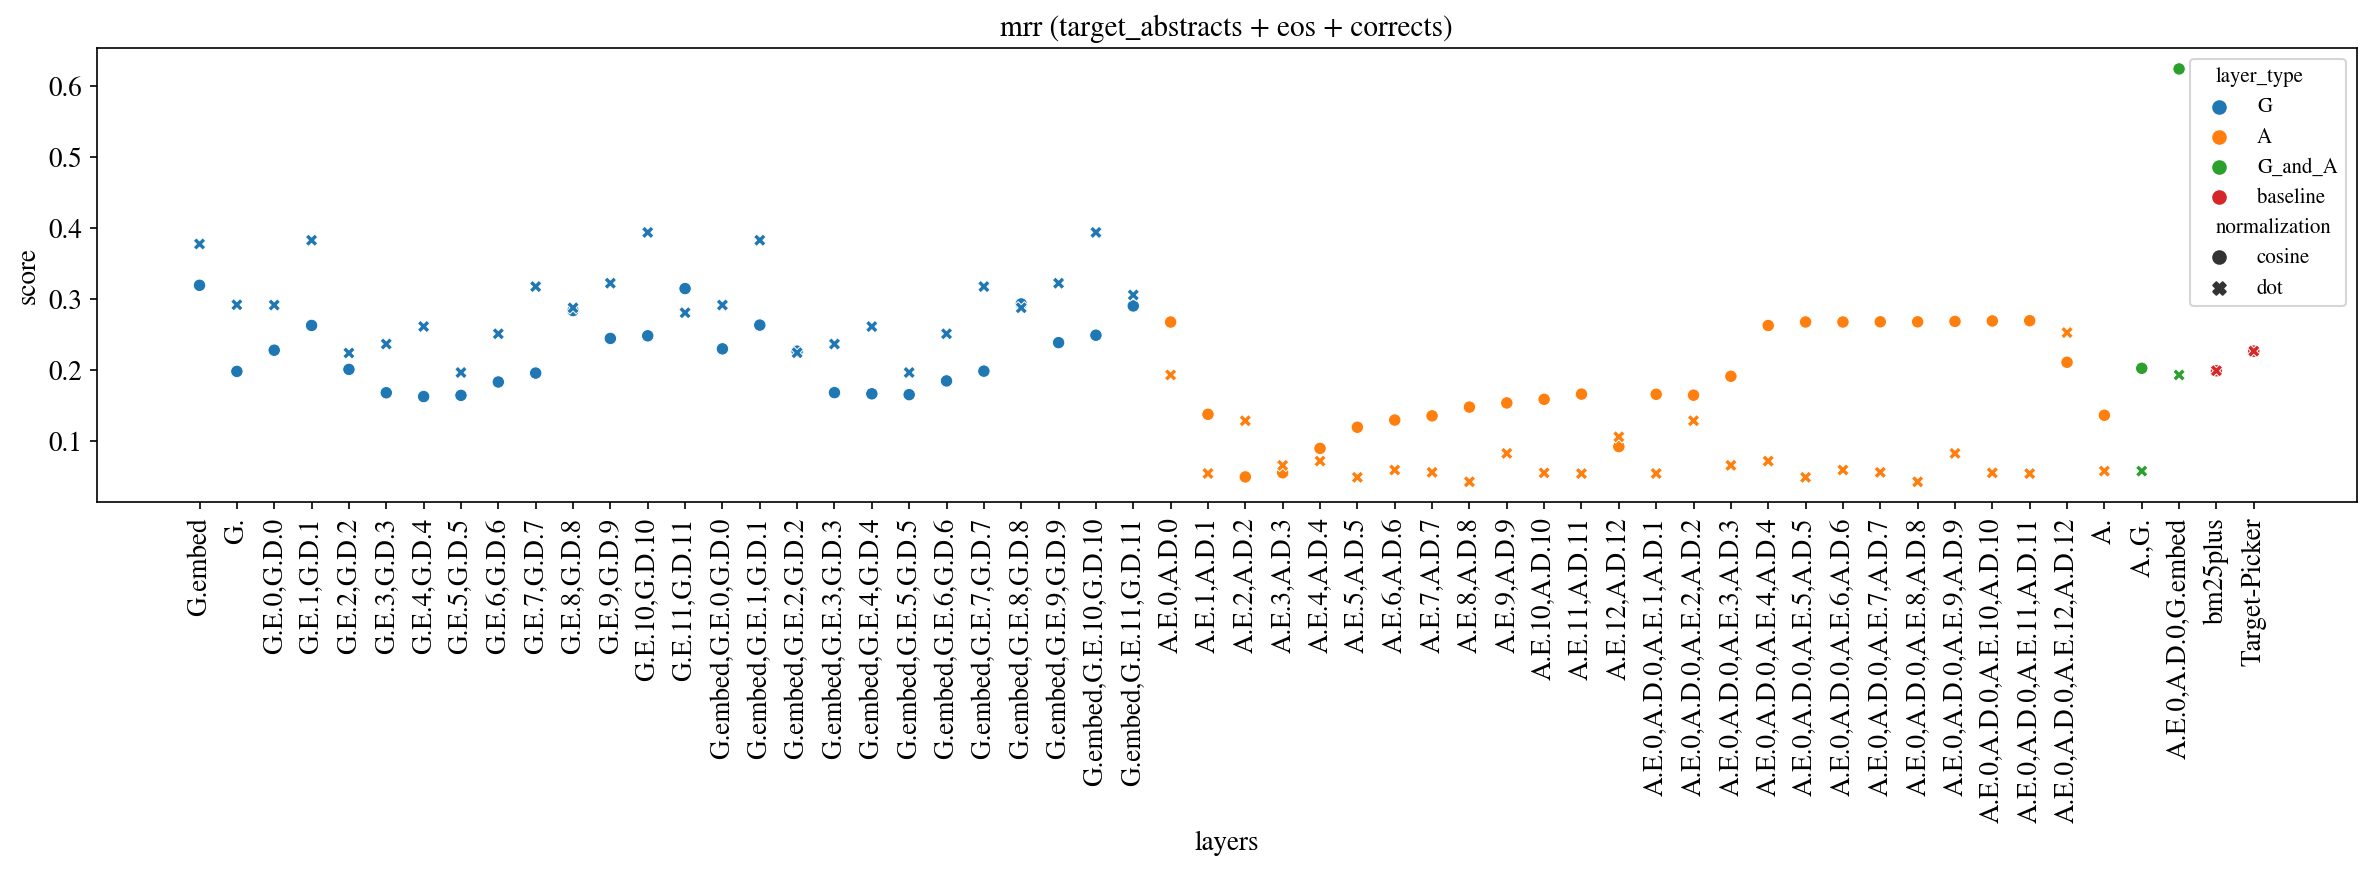

In [20]:
for eos in ("no_eos", "eos"):
  for subset in ("corrects", ):
    visualize_one_experiment(path=f'/reranker/bm25plusv2_4ckpt_mean_multi_{eos}__{subset}.json', suffix=f"{eos} + {subset}")

In [ ]:
def get_nn_abstracts(res):
  """Get list of abstracts and their scores (dotproduct score)"""
  print(res['example']['inputs_pretokenized']," -> ", res['example']['targets_pretokenized'])
  abstracts = np.array(res['nn_abstracts'])
  for i, abstract in enumerate(abstracts):
    try:
      abstract['score'] = res['nn_scores'][i]
    except KeyError:
      abstract['score'] = res['nn']['scores'][i]
  df = pd.DataFrame(pd.json_normalize(abstracts)).round(3)
  df['inputs_pretokenized'] = df['inputs_pretokenized'].str.slice(0,512)
  return df

In [ ]:
path = '/reranker/bm2plus_wbaselines_eos_all.json'
with open(METRICS_DIR + path) as f:
      reranker_metrics = json.load(f)
      if 'mrr' not in reranker_metrics['dot']['random']:
          reranker_metrics['dot']['random'] = reranker_metrics['cosine']['random'] = average_metrics(reranker_metrics['dot']['random'])

In [ ]:
i = 2
sim = 'cosine'
abstracts = get_nn_abstracts(reranker_metrics[sim]['activations.encoder.block.11,activations.decoder.block.11']['samples'][i])
display(abstracts)
abstracts = get_nn_abstracts(reranker_metrics[sim]['activations.encoder.block.0,activations.decoder.block.0']['samples'][i])
display(abstracts)

In [ ]:
i = 2
sim = 'cosine'
abstracts = get_nn_abstracts(reranker_metrics[sim]['gradients.encoder.block.11,gradients.decoder.block.11']['samples'][i])
display(abstracts)
abstracts = get_nn_abstracts(reranker_metrics[sim]['gradients.encoder.block.0,gradients.decoder.block.0']['samples'][i])
display(abstracts)
abstracts = get_nn_abstracts(reranker_metrics[sim]['gradients.shared']['samples'][i])
display(abstracts)